In [113]:
%%file data_first256K_sampled.json
{"buf_size_compressed":578437,"buf_size_uncompressed":3038442,"fallback_mem":524368,"fallback_rows":193,"general_case":"Struct[(str,'actor'->Struct[(str,'avatar_url'->str),(str,'gravatar_id'=>str),(str,'id'=>i64),(str,'login'=>str),(str,'url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'org'=>Struct[(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str),(str,'id'->i64),(str,'login'->str)]),(str,'payload'->Struct[(str,'action'=>str),(str,'comment'=>Struct[(str,'created_at'->str),(str,'updated_at'->str),(str,'user'->Struct[(str,'gravatar_id'->str),(str,'id'->i64),(str,'url'->str),(str,'login'->str),(str,'avatar_url'->str)]),(str,'body'->str),(str,'id'->i64),(str,'url'->str)]),(str,'commits'=>List[Struct[(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'sha'->str),(str,'message'->str),(str,'url'->str)]]),(str,'description'=>str),(str,'download'=>Struct[(str,'created_at'->str),(str,'content_type'->str),(str,'name'->str),(str,'id'->i64),(str,'description'->str),(str,'html_url'->str),(str,'size'->i64),(str,'url'->str),(str,'download_count'->i64)]),(str,'forkee'=>Struct[(str,'clone_url'->str),(str,'created_at'->str),(str,'description'->str),(str,'fork'->boolean),(str,'forks'->i64),(str,'git_url'->str),(str,'homepage'->str),(str,'html_url'->str),(str,'id'->i64),(str,'language'->str),(str,'master_branch'->null),(str,'name'->str),(str,'open_issues'->i64),(str,'owner'->Struct[(str,'gravatar_id'->str),(str,'id'->i64),(str,'url'->str),(str,'login'->str),(str,'avatar_url'->str)]),(str,'private'->boolean),(str,'public'->boolean),(str,'pushed_at'->str),(str,'size'->i64),(str,'ssh_url'->str),(str,'svn_url'->str),(str,'updated_at'->str),(str,'url'->str),(str,'watchers'->i64)]),(str,'gist'=>Struct[(str,'comments'->i64),(str,'created_at'->str),(str,'description'->str),(str,'files'->{}),(str,'git_pull_url'->str),(str,'git_push_url'->str),(str,'html_url'->str),(str,'id'->str),(str,'public'->boolean),(str,'updated_at'->str),(str,'url'->str),(str,'user'->null)]),(str,'head'=>str),(str,'issue'=>Struct[(str,'assignee'->null),(str,'body'->str),(str,'closed_at'->Option[str]),(str,'comments'->i64),(str,'created_at'->str),(str,'html_url'->str),(str,'id'->i64),(str,'labels'->[]),(str,'milestone'->null),(str,'number'->i64),(str,'pull_request'->Struct[(str,'diff_url'->Option[str]),(str,'html_url'->Option[str]),(str,'patch_url'->Option[str])]),(str,'state'->str),(str,'title'->str),(str,'updated_at'->str),(str,'url'->str),(str,'user'->Struct[(str,'gravatar_id'->str),(str,'id'->i64),(str,'url'->str),(str,'login'->str),(str,'avatar_url'->str)])]),(str,'master_branch'=>str),(str,'member'=>Struct[(str,'gravatar_id'->str),(str,'id'->i64),(str,'url'->str),(str,'login'->str),(str,'avatar_url'->str)]),(str,'number'=>i64),(str,'pages'=>List[Struct[(str,'summary'->null),(str,'page_name'->str),(str,'sha'->str),(str,'action'->str),(str,'title'->str),(str,'html_url'->str)]]),(str,'pull_request'=>Struct[(str,'_links'->Struct[(str,'review_comments'->Struct[(str,'href'->str)]),(str,'comments'->Struct[(str,'href'->str)]),(str,'html'->Struct[(str,'href'->str)]),(str,'self'->Struct[(str,'href'->str)])]),(str,'additions'->i64),(str,'base'->Struct[(str,'label'->str),(str,'ref'->str),(str,'repo'->Struct[(str,'clone_url'->str),(str,'created_at'->str),(str,'description'->str),(str,'fork'->boolean),(str,'forks'->i64),(str,'git_url'->str),(str,'homepage'->str),(str,'html_url'->str),(str,'id'->i64),(str,'language'->str),(str,'master_branch'->null),(str,'name'->str),(str,'open_issues'->i64),(str,'owner'->Struct[(str,'gravatar_id'->str),(str,'id'->i64),(str,'url'->str),(str,'login'->str),(str,'avatar_url'->str)]),(str,'private'->boolean),(str,'pushed_at'->str),(str,'size'->i64),(str,'ssh_url'->str),(str,'svn_url'->str),(str,'updated_at'->str),(str,'url'->str),(str,'watchers'->i64)]),(str,'sha'->str),(str,'user'->Struct[(str,'gravatar_id'->str),(str,'id'->i64),(str,'url'->str),(str,'login'->str),(str,'avatar_url'->str)])]),(str,'body'->str),(str,'changed_files'->i64),(str,'closed_at'->str),(str,'comments'->i64),(str,'commits'->i64),(str,'created_at'->str),(str,'deletions'->i64),(str,'diff_url'->str),(str,'head'->Struct[(str,'label'->str),(str,'ref'->str),(str,'repo'->Struct[(str,'clone_url'->str),(str,'created_at'->str),(str,'description'->str),(str,'fork'->boolean),(str,'forks'->i64),(str,'git_url'->str),(str,'homepage'->str),(str,'html_url'->str),(str,'id'->i64),(str,'language'->str),(str,'master_branch'->null),(str,'name'->str),(str,'open_issues'->i64),(str,'owner'->Struct[(str,'gravatar_id'->str),(str,'id'->i64),(str,'url'->str),(str,'login'->str),(str,'avatar_url'->str)]),(str,'private'->boolean),(str,'pushed_at'->str),(str,'size'->i64),(str,'ssh_url'->str),(str,'svn_url'->str),(str,'updated_at'->str),(str,'url'->str),(str,'watchers'->i64)]),(str,'sha'->str),(str,'user'->Struct[(str,'gravatar_id'->str),(str,'id'->i64),(str,'url'->str),(str,'login'->str),(str,'avatar_url'->str)])]),(str,'html_url'->str),(str,'id'->i64),(str,'issue_url'->str),(str,'mergeable'->null),(str,'merged'->boolean),(str,'merged_at'->str),(str,'merged_by'->Struct[(str,'gravatar_id'->str),(str,'id'->i64),(str,'url'->str),(str,'login'->str),(str,'avatar_url'->str)]),(str,'number'->i64),(str,'patch_url'->str),(str,'review_comments'->i64),(str,'state'->str),(str,'title'->str),(str,'updated_at'->str),(str,'url'->str),(str,'user'->Struct[(str,'gravatar_id'->str),(str,'id'->i64),(str,'url'->str),(str,'login'->str),(str,'avatar_url'->str)])]),(str,'push_id'=>i64),(str,'ref'=>Option[str]),(str,'ref_type'=>str),(str,'size'=>i64),(str,'target'=>Struct[(str,'avatar_url'->str),(str,'bio'->Option[str]),(str,'blog'->Option[str]),(str,'company'->Option[str]),(str,'created_at'->str),(str,'email'->Option[str]),(str,'followers'->i64),(str,'following'->i64),(str,'gravatar_id'->str),(str,'hireable'->boolean),(str,'html_url'->str),(str,'id'->i64),(str,'location'->Option[str]),(str,'login'->str),(str,'name'->str),(str,'public_gists'->i64),(str,'public_repos'->i64),(str,'type'->str),(str,'url'->str)])]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'=>i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":2977950,"general_rows":1107,"mode":"hyper","normal_case":"Struct[(str,'actor'->Struct[(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str),(str,'id'->i64),(str,'login'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'payload'->Struct[(str,'commits'->List[Struct[(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'sha'->str),(str,'message'->str),(str,'url'->str)]]),(str,'head'->str),(str,'push_id'->i64),(str,'ref'->str),(str,'size'->i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'url'->str),(str,'id'->i64),(str,'name'->str)]),(str,'type'->str)]","normal_mem":1138397,"normal_rows":1102,"path":"/data/github_sample/2011-11-26-13.json.gz","total_rows":2402}
{"buf_size_compressed":1621128,"buf_size_uncompressed":7009697,"fallback_mem":4619435,"fallback_rows":3014,"general_case":"Struct[(str,'actor'->str),(str,'actor_attributes'->Struct[(str,'blog'=>str),(str,'company'=>str),(str,'email'->str),(str,'gravatar_id'->str),(str,'location'=>str),(str,'login'->str),(str,'name'=>str),(str,'type'->str)]),(str,'created_at'->str),(str,'payload'->Struct[(str,'action'=>str),(str,'comment_id'=>i64),(str,'desc'=>str),(str,'description'=>str),(str,'head'=>str),(str,'id'=>i64),(str,'issue'=>i64),(str,'issue_id'=>i64),(str,'master_branch'=>str),(str,'name'=>str),(str,'number'=>i64),(str,'pages'=>List[Struct[(str,'html_url'->str),(str,'summary'->null),(str,'action'->str),(str,'page_name'->str),(str,'title'->str),(str,'sha'->str)]]),(str,'pull_request'=>Struct[(str,'number'->i64),(str,'milestone'->null),(str,'diff_url'->str),(str,'user'->Struct[(str,'id'->i64),(str,'avatar_url'->str),(str,'url'->str),(str,'gravatar_id'->str),(str,'login'->str)]),(str,'id'->i64),(str,'deletions'->i64),(str,'closed_at'->str),(str,'review_comments'->i64),(str,'assignee'->null),(str,'mergeable'->null),(str,'additions'->i64),(str,'comments'->i64),(str,'url'->str),(str,'patch_url'->str),(str,'merged_by'->Struct[(str,'id'->i64),(str,'avatar_url'->str),(str,'url'->str),(str,'gravatar_id'->str),(str,'login'->str)]),(str,'body'->str),(str,'merge_commit_sha'->str),(str,'changed_files'->i64),(str,'updated_at'->str),(str,'issue_url'->str),(str,'merged'->boolean),(str,'title'->str),(str,'mergeable_state'->str),(str,'commits'->i64),(str,'html_url'->str),(str,'created_at'->str),(str,'base'->Struct[(str,'user'->Struct[(str,'id'->i64),(str,'avatar_url'->str),(str,'url'->str),(str,'gravatar_id'->str),(str,'login'->str)]),(str,'repo'->Struct[(str,'pushed_at'->str),(str,'fork'->boolean),(str,'id'->i64),(str,'clone_url'->str),(str,'ssh_url'->str),(str,'description'->str),(str,'mirror_url'->null),(str,'watchers'->i64),(str,'has_issues'->boolean),(str,'url'->str),(str,'open_issues_count'->i64),(str,'has_downloads'->boolean),(str,'name'->str),(str,'homepage'->str),(str,'svn_url'->str),(str,'language'->str),(str,'forks_count'->i64),(str,'full_name'->str),(str,'updated_at'->str),(str,'private'->boolean),(str,'watchers_count'->i64),(str,'forks'->i64),(str,'open_issues'->i64),(str,'html_url'->str),(str,'created_at'->str),(str,'has_wiki'->boolean),(str,'size'->i64),(str,'git_url'->str),(str,'owner'->Struct[(str,'id'->i64),(str,'avatar_url'->str),(str,'url'->str),(str,'gravatar_id'->str),(str,'login'->str)])]),(str,'label'->str),(str,'sha'->str),(str,'ref'->str)]),(str,'merged_at'->str),(str,'head'->Struct[(str,'user'->Struct[(str,'id'->i64),(str,'avatar_url'->str),(str,'url'->str),(str,'gravatar_id'->str),(str,'login'->str)]),(str,'repo'->Struct[(str,'pushed_at'->str),(str,'fork'->boolean),(str,'id'->i64),(str,'clone_url'->str),(str,'ssh_url'->str),(str,'description'->str),(str,'mirror_url'->null),(str,'watchers'->i64),(str,'has_issues'->boolean),(str,'master_branch'->str),(str,'url'->str),(str,'default_branch'->str),(str,'open_issues_count'->i64),(str,'has_downloads'->boolean),(str,'name'->str),(str,'homepage'->str),(str,'svn_url'->str),(str,'language'->str),(str,'forks_count'->i64),(str,'full_name'->str),(str,'updated_at'->str),(str,'private'->boolean),(str,'watchers_count'->i64),(str,'forks'->i64),(str,'open_issues'->i64),(str,'html_url'->str),(str,'created_at'->str),(str,'has_wiki'->boolean),(str,'size'->i64),(str,'git_url'->str),(str,'owner'->Struct[(str,'id'->i64),(str,'avatar_url'->str),(str,'url'->str),(str,'gravatar_id'->str),(str,'login'->str)])]),(str,'label'->str),(str,'sha'->str),(str,'ref'->str)]),(str,'state'->str),(str,'_links'->Struct[(str,'review_comments'->Struct[(str,'href'->str)]),(str,'issue'->Struct[(str,'href'->str)]),(str,'comments'->Struct[(str,'href'->str)]),(str,'html'->Struct[(str,'href'->str)]),(str,'self'->Struct[(str,'href'->str)])])]),(str,'ref'=>Option[str]),(str,'ref_type'=>str),(str,'shas'=>List[(str,str,str,str,boolean)]),(str,'size'=>i64),(str,'target'=>Struct[(str,'followers'->i64),(str,'gravatar_id'->str),(str,'id'->i64),(str,'login'->str),(str,'repos'->i64)]),(str,'url'=>str)]),(str,'public'->boolean),(str,'repository'=>Struct[(str,'created_at'->str),(str,'description'=>str),(str,'fork'->boolean),(str,'forks'->i64),(str,'has_downloads'->boolean),(str,'has_issues'->boolean),(str,'has_wiki'->boolean),(str,'homepage'=>str),(str,'id'->i64),(str,'language'=>str),(str,'master_branch'=>str),(str,'name'->str),(str,'open_issues'->i64),(str,'organization'=>str),(str,'owner'->str),(str,'private'->boolean),(str,'pushed_at'->str),(str,'size'->i64),(str,'stargazers'->i64),(str,'url'->str),(str,'watchers'->i64)]),(str,'type'->str),(str,'url'->str)]","general_mem":5492308,"general_rows":2578,"mode":"hyper","normal_case":"Struct[(str,'actor'->str),(str,'actor_attributes'->Struct[(str,'email'->str),(str,'gravatar_id'->str),(str,'login'->str),(str,'type'->str)]),(str,'created_at'->str),(str,'payload'->Struct[(str,'head'->str),(str,'ref'->str),(str,'shas'->List[(str,str,str,str,boolean)]),(str,'size'->i64)]),(str,'public'->boolean),(str,'repository'->Struct[(str,'created_at'->str),(str,'description'->str),(str,'fork'->boolean),(str,'forks'->i64),(str,'has_downloads'->boolean),(str,'has_issues'->boolean),(str,'has_wiki'->boolean),(str,'id'->i64),(str,'language'->str),(str,'name'->str),(str,'open_issues'->i64),(str,'owner'->str),(str,'private'->boolean),(str,'pushed_at'->str),(str,'size'->i64),(str,'stargazers'->i64),(str,'url'->str),(str,'watchers'->i64)]),(str,'type'->str),(str,'url'->str)]","normal_mem":74119,"normal_rows":53,"path":"/data/github_sample/2012-11-08-17.json.gz","total_rows":5645}
{"buf_size_compressed":1667387,"buf_size_uncompressed":9078561,"fallback_mem":3727628,"fallback_rows":3054,"general_case":"Struct[(str,'actor'->str),(str,'actor_attributes'->Struct[(str,'blog'=>str),(str,'company'=>str),(str,'email'->str),(str,'gravatar_id'->str),(str,'location'=>str),(str,'login'->str),(str,'name'=>str),(str,'type'->str)]),(str,'created_at'->str),(str,'payload'->Struct[(str,'action'=>str),(str,'comment_id'=>i64),(str,'head'=>str),(str,'issue'=>i64),(str,'issue_id'=>i64),(str,'number'=>i64),(str,'pages'=>List[Struct[(str,'page_name'->str),(str,'title'->str),(str,'summary'->null),(str,'action'->str),(str,'sha'->str),(str,'html_url'->str)]]),(str,'ref'=>str),(str,'shas'=>List[(str,str,str,str,boolean)]),(str,'size'=>i64)]),(str,'public'->boolean),(str,'repository'->Struct[(str,'created_at'->str),(str,'description'->str),(str,'fork'->boolean),(str,'forks'->i64),(str,'has_downloads'->boolean),(str,'has_issues'->boolean),(str,'has_wiki'->boolean),(str,'homepage'=>str),(str,'id'->i64),(str,'language'=>str),(str,'master_branch'->str),(str,'name'->str),(str,'open_issues'->i64),(str,'organization'=>str),(str,'owner'->str),(str,'private'->boolean),(str,'pushed_at'->str),(str,'size'->i64),(str,'stargazers'->i64),(str,'url'->str),(str,'watchers'->i64)]),(str,'type'->str),(str,'url'->str)]","general_mem":2583515,"general_rows":2690,"mode":"hyper","normal_case":"Struct[(str,'created_at'->str),(str,'payload'->Struct[(str,'action'->str),(str,'issue'->i64),(str,'number'->i64)]),(str,'public'->boolean),(str,'type'->str),(str,'url'->str),(str,'actor'->str),(str,'actor_attributes'->Struct[(str,'login'->str),(str,'type'->str),(str,'gravatar_id'->str),(str,'name'->str),(str,'blog'->str),(str,'location'->str),(str,'email'->str)]),(str,'repository'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str),(str,'description'->str),(str,'watchers'->i64),(str,'stargazers'->i64),(str,'forks'->i64),(str,'fork'->boolean),(str,'size'->i64),(str,'owner'->str),(str,'private'->boolean),(str,'open_issues'->i64),(str,'has_issues'->boolean),(str,'has_downloads'->boolean),(str,'has_wiki'->boolean),(str,'created_at'->str),(str,'pushed_at'->str),(str,'master_branch'->str)])]","normal_mem":408131,"normal_rows":545,"path":"/data/github_sample/2013-07-27-3.json.gz","total_rows":6289}
{"buf_size_compressed":6415260,"buf_size_uncompressed":36183328,"fallback_mem":14005148,"fallback_rows":10860,"general_case":"Struct[(str,'actor'->str),(str,'actor_attributes'->Struct[(str,'blog'=>str),(str,'company'=>str),(str,'email'->str),(str,'gravatar_id'->str),(str,'location'=>str),(str,'login'->str),(str,'name'=>str),(str,'type'->str)]),(str,'created_at'->str),(str,'payload'->Struct[(str,'action'=>str),(str,'head'=>str),(str,'ref'=>str),(str,'shas'=>List[(str,str,str,str,boolean)]),(str,'size'=>i64)]),(str,'public'->boolean),(str,'repository'->Struct[(str,'created_at'->str),(str,'description'->str),(str,'fork'->boolean),(str,'forks'->i64),(str,'has_downloads'->boolean),(str,'has_issues'->boolean),(str,'has_wiki'->boolean),(str,'homepage'=>str),(str,'id'->i64),(str,'language'=>str),(str,'master_branch'->str),(str,'name'->str),(str,'open_issues'->i64),(str,'organization'=>str),(str,'owner'->str),(str,'private'->boolean),(str,'pushed_at'->str),(str,'size'->i64),(str,'stargazers'->i64),(str,'url'->str),(str,'watchers'->i64)]),(str,'type'->str),(str,'url'->str)]","general_mem":7252512,"general_rows":8089,"mode":"hyper","normal_case":"Struct[(str,'created_at'->str),(str,'payload'->Struct[(str,'shas'->List[(str,str,str,str,boolean)]),(str,'size'->i64),(str,'ref'->str),(str,'head'->str)]),(str,'public'->boolean),(str,'type'->str),(str,'url'->str),(str,'actor'->str),(str,'actor_attributes'->Struct[(str,'login'->str),(str,'type'->str),(str,'gravatar_id'->str),(str,'name'->str),(str,'company'->str),(str,'blog'->str),(str,'location'->str),(str,'email'->str)]),(str,'repository'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str),(str,'description'->str),(str,'watchers'->i64),(str,'stargazers'->i64),(str,'forks'->i64),(str,'fork'->boolean),(str,'size'->i64),(str,'owner'->str),(str,'private'->boolean),(str,'open_issues'->i64),(str,'has_issues'->boolean),(str,'has_downloads'->boolean),(str,'has_wiki'->boolean),(str,'language'->str),(str,'created_at'->str),(str,'pushed_at'->str),(str,'master_branch'->str)])]","normal_mem":82495,"normal_rows":55,"path":"/data/github_sample/2014-04-09-12.json.gz","total_rows":19004}
{"buf_size_compressed":5671436,"buf_size_uncompressed":39495303,"fallback_mem":466280,"fallback_rows":909,"general_case":"Struct[(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'org'=>Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'payload'->Struct[(str,'action'=>str),(str,'before'=>str),(str,'commits'=>List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'email'->str),(str,'name'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]]),(str,'distinct_size'=>i64),(str,'head'=>str),(str,'push_id'=>i64),(str,'ref'=>str),(str,'size'=>i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":4367018,"general_rows":8420,"mode":"hyper","normal_case":"Struct[(str,'id'->str),(str,'type'->str),(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'email'->str),(str,'name'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'created_at'->str)]","normal_mem":9120888,"normal_rows":9367,"path":"/data/github_sample/2015-09-06-9.json.gz","total_rows":18696}
{"buf_size_compressed":8965141,"buf_size_uncompressed":62444550,"fallback_mem":699399,"fallback_rows":1343,"general_case":"Struct[(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'org'=>Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'payload'->Struct[(str,'action'=>str),(str,'before'=>str),(str,'commits'=>List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'email'->str),(str,'name'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]]),(str,'distinct_size'=>i64),(str,'head'=>str),(str,'push_id'=>i64),(str,'ref'=>str),(str,'size'=>i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":6374281,"general_rows":12126,"mode":"hyper","normal_case":"Struct[(str,'id'->str),(str,'type'->str),(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'email'->str),(str,'name'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'created_at'->str)]","normal_mem":14681626,"normal_rows":14267,"path":"/data/github_sample/2016-01-07-7.json.gz","total_rows":27736}
{"buf_size_compressed":11628798,"buf_size_uncompressed":85768998,"fallback_mem":64009559,"fallback_rows":16529,"general_case":"Struct[(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'org'=>Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":0,"general_rows":0,"mode":"hyper","normal_case":"Struct[(str,'id'->str),(str,'type'->str),(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'created_at'->str)]","normal_mem":18423824,"normal_rows":19038,"path":"/data/github_sample/2017-02-10-5.json.gz","total_rows":35567}
{"buf_size_compressed":33770287,"buf_size_uncompressed":243258079,"fallback_mem":140619690,"fallback_rows":11642,"general_case":"Struct[(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'org'=>Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'payload'->Struct[(str,'action'=>str),(str,'before'=>str),(str,'comment'=>Struct[(str,'url'->str),(str,'html_url'->str),(str,'issue_url'->str),(str,'id'->i64),(str,'node_id'->str),(str,'user'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)]),(str,'created_at'->str),(str,'updated_at'->str),(str,'author_association'->str),(str,'body'->str)]),(str,'commits'=>List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]]),(str,'description'=>Option[str]),(str,'distinct_size'=>i64),(str,'forkee'=>Struct[(str,'id'->i64),(str,'node_id'->str),(str,'name'->str),(str,'full_name'->str),(str,'private'->boolean),(str,'owner'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)]),(str,'html_url'->str),(str,'description'->str),(str,'fork'->boolean),(str,'url'->str),(str,'forks_url'->str),(str,'keys_url'->str),(str,'collaborators_url'->str),(str,'teams_url'->str),(str,'hooks_url'->str),(str,'issue_events_url'->str),(str,'events_url'->str),(str,'assignees_url'->str),(str,'branches_url'->str),(str,'tags_url'->str),(str,'blobs_url'->str),(str,'git_tags_url'->str),(str,'git_refs_url'->str),(str,'trees_url'->str),(str,'statuses_url'->str),(str,'languages_url'->str),(str,'stargazers_url'->str),(str,'contributors_url'->str),(str,'subscribers_url'->str),(str,'subscription_url'->str),(str,'commits_url'->str),(str,'git_commits_url'->str),(str,'comments_url'->str),(str,'issue_comment_url'->str),(str,'contents_url'->str),(str,'compare_url'->str),(str,'merges_url'->str),(str,'archive_url'->str),(str,'downloads_url'->str),(str,'issues_url'->str),(str,'pulls_url'->str),(str,'milestones_url'->str),(str,'notifications_url'->str),(str,'labels_url'->str),(str,'releases_url'->str),(str,'deployments_url'->str),(str,'created_at'->str),(str,'updated_at'->str),(str,'pushed_at'->str),(str,'git_url'->str),(str,'ssh_url'->str),(str,'clone_url'->str),(str,'svn_url'->str),(str,'homepage'->null),(str,'size'->i64),(str,'stargazers_count'->i64),(str,'watchers_count'->i64),(str,'language'->null),(str,'has_issues'->boolean),(str,'has_projects'->boolean),(str,'has_downloads'->boolean),(str,'has_wiki'->boolean),(str,'has_pages'->boolean),(str,'forks_count'->i64),(str,'mirror_url'->null),(str,'archived'->boolean),(str,'open_issues_count'->i64),(str,'license'->null),(str,'forks'->i64),(str,'open_issues'->i64),(str,'watchers'->i64),(str,'default_branch'->str),(str,'public'->boolean)]),(str,'head'=>str),(str,'issue'=>Struct[(str,'url'->str),(str,'repository_url'->str),(str,'labels_url'->str),(str,'comments_url'->str),(str,'events_url'->str),(str,'html_url'->str),(str,'id'->i64),(str,'node_id'->str),(str,'number'->i64),(str,'title'->str),(str,'user'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)]),(str,'labels'->[]),(str,'state'->str),(str,'locked'->boolean),(str,'assignee'->null),(str,'assignees'->[]),(str,'milestone'->null),(str,'comments'->i64),(str,'created_at'->str),(str,'updated_at'->str),(str,'closed_at'->null),(str,'author_association'->str),(str,'body'->str)]),(str,'master_branch'=>str),(str,'number'=>i64),(str,'pull_request'=>Struct[(str,'_links'->Struct[(str,'self'->Struct[(str,'href'->str)]),(str,'html'->Struct[(str,'href'->str)]),(str,'issue'->Struct[(str,'href'->str)]),(str,'comments'->Struct[(str,'href'->str)]),(str,'review_comments'->Struct[(str,'href'->str)]),(str,'review_comment'->Struct[(str,'href'->str)]),(str,'commits'->Struct[(str,'href'->str)]),(str,'statuses'->Struct[(str,'href'->str)])]),(str,'additions'->i64),(str,'assignee'->null),(str,'assignees'->[]),(str,'author_association'->str),(str,'base'->Struct[(str,'label'->str),(str,'ref'->str),(str,'repo'->Struct[(str,'archive_url'->str),(str,'archived'->boolean),(str,'assignees_url'->str),(str,'blobs_url'->str),(str,'branches_url'->str),(str,'clone_url'->str),(str,'collaborators_url'->str),(str,'comments_url'->str),(str,'commits_url'->str),(str,'compare_url'->str),(str,'contents_url'->str),(str,'contributors_url'->str),(str,'created_at'->str),(str,'default_branch'->str),(str,'deployments_url'->str),(str,'description'->Option[str]),(str,'downloads_url'->str),(str,'events_url'->str),(str,'fork'->boolean),(str,'forks'->i64),(str,'forks_count'->i64),(str,'forks_url'->str),(str,'full_name'->str),(str,'git_commits_url'->str),(str,'git_refs_url'->str),(str,'git_tags_url'->str),(str,'git_url'->str),(str,'has_downloads'->boolean),(str,'has_issues'->boolean),(str,'has_pages'->boolean),(str,'has_projects'->boolean),(str,'has_wiki'->boolean),(str,'homepage'->null),(str,'hooks_url'->str),(str,'html_url'->str),(str,'id'->i64),(str,'issue_comment_url'->str),(str,'issue_events_url'->str),(str,'issues_url'->str),(str,'keys_url'->str),(str,'labels_url'->str),(str,'language'->Option[str]),(str,'languages_url'->str),(str,'license'->Option[Struct[(str,'key'->str),(str,'name'->str),(str,'spdx_id'->str),(str,'url'->str),(str,'node_id'->str)]]),(str,'merges_url'->str),(str,'milestones_url'->str),(str,'mirror_url'->null),(str,'name'->str),(str,'node_id'->str),(str,'notifications_url'->str),(str,'open_issues'->i64),(str,'open_issues_count'->i64),(str,'owner'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)]),(str,'private'->boolean),(str,'pulls_url'->str),(str,'pushed_at'->str),(str,'releases_url'->str),(str,'size'->i64),(str,'ssh_url'->str),(str,'stargazers_count'->i64),(str,'stargazers_url'->str),(str,'statuses_url'->str),(str,'subscribers_url'->str),(str,'subscription_url'->str),(str,'svn_url'->str),(str,'tags_url'->str),(str,'teams_url'->str),(str,'trees_url'->str),(str,'updated_at'->str),(str,'url'->str),(str,'watchers'->i64),(str,'watchers_count'->i64)]),(str,'sha'->str),(str,'user'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)])]),(str,'body'->str),(str,'changed_files'->i64),(str,'closed_at'->null),(str,'comments'->i64),(str,'comments_url'->str),(str,'commits'->i64),(str,'commits_url'->str),(str,'created_at'->str),(str,'deletions'->i64),(str,'diff_url'->str),(str,'head'->Struct[(str,'label'->str),(str,'ref'->str),(str,'repo'->Struct[(str,'archive_url'->str),(str,'archived'->boolean),(str,'assignees_url'->str),(str,'blobs_url'->str),(str,'branches_url'->str),(str,'clone_url'->str),(str,'collaborators_url'->str),(str,'comments_url'->str),(str,'commits_url'->str),(str,'compare_url'->str),(str,'contents_url'->str),(str,'contributors_url'->str),(str,'created_at'->str),(str,'default_branch'->str),(str,'deployments_url'->str),(str,'description'->Option[str]),(str,'downloads_url'->str),(str,'events_url'->str),(str,'fork'->boolean),(str,'forks'->i64),(str,'forks_count'->i64),(str,'forks_url'->str),(str,'full_name'->str),(str,'git_commits_url'->str),(str,'git_refs_url'->str),(str,'git_tags_url'->str),(str,'git_url'->str),(str,'has_downloads'->boolean),(str,'has_issues'->boolean),(str,'has_pages'->boolean),(str,'has_projects'->boolean),(str,'has_wiki'->boolean),(str,'homepage'->null),(str,'hooks_url'->str),(str,'html_url'->str),(str,'id'->i64),(str,'issue_comment_url'->str),(str,'issue_events_url'->str),(str,'issues_url'->str),(str,'keys_url'->str),(str,'labels_url'->str),(str,'language'->Option[str]),(str,'languages_url'->str),(str,'license'->Option[Struct[(str,'key'->str),(str,'name'->str),(str,'spdx_id'->str),(str,'url'->str),(str,'node_id'->str)]]),(str,'merges_url'->str),(str,'milestones_url'->str),(str,'mirror_url'->null),(str,'name'->str),(str,'node_id'->str),(str,'notifications_url'->str),(str,'open_issues'->i64),(str,'open_issues_count'->i64),(str,'owner'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)]),(str,'private'->boolean),(str,'pulls_url'->str),(str,'pushed_at'->str),(str,'releases_url'->str),(str,'size'->i64),(str,'ssh_url'->str),(str,'stargazers_count'->i64),(str,'stargazers_url'->str),(str,'statuses_url'->str),(str,'subscribers_url'->str),(str,'subscription_url'->str),(str,'svn_url'->str),(str,'tags_url'->str),(str,'teams_url'->str),(str,'trees_url'->str),(str,'updated_at'->str),(str,'url'->str),(str,'watchers'->i64),(str,'watchers_count'->i64)]),(str,'sha'->str),(str,'user'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)])]),(str,'html_url'->str),(str,'id'->i64),(str,'issue_url'->str),(str,'labels'->[]),(str,'locked'->boolean),(str,'maintainer_can_modify'->boolean),(str,'merge_commit_sha'->null),(str,'mergeable'->null),(str,'mergeable_state'->str),(str,'merged'->boolean),(str,'merged_at'->null),(str,'merged_by'->null),(str,'milestone'->null),(str,'node_id'->str),(str,'number'->i64),(str,'patch_url'->str),(str,'rebaseable'->null),(str,'requested_reviewers'->[]),(str,'requested_teams'->[]),(str,'review_comment_url'->str),(str,'review_comments'->i64),(str,'review_comments_url'->str),(str,'state'->str),(str,'statuses_url'->str),(str,'title'->str),(str,'updated_at'->str),(str,'url'->str),(str,'user'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)])]),(str,'push_id'=>i64),(str,'pusher_type'=>str),(str,'ref'=>Option[str]),(str,'ref_type'=>str),(str,'size'=>i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":135488818,"general_rows":26557,"mode":"hyper","normal_case":"Struct[(str,'id'->str),(str,'type'->str),(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'created_at'->str)]","normal_mem":42152177,"normal_rows":38512,"path":"/data/github_sample/2018-11-28-10.json.gz","total_rows":76711}
{"buf_size_compressed":15628233,"buf_size_uncompressed":116966114,"fallback_mem":33170147,"fallback_rows":2451,"general_case":"Struct[(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'org'=>Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'payload'->Struct[(str,'action'=>str),(str,'before'=>str),(str,'comment'=>Struct[(str,'author_association'->str),(str,'body'->str),(str,'commit_id'=>str),(str,'created_at'->str),(str,'html_url'->str),(str,'id'->i64),(str,'issue_url'=>str),(str,'line'=>null),(str,'node_id'->str),(str,'path'=>null),(str,'position'=>null),(str,'updated_at'->str),(str,'url'->str),(str,'user'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)])]),(str,'commits'=>List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]]),(str,'description'=>Option[str]),(str,'distinct_size'=>i64),(str,'head'=>str),(str,'issue'=>Struct[(str,'assignee'->null),(str,'assignees'->[]),(str,'author_association'->str),(str,'body'->str),(str,'closed_at'->Option[str]),(str,'comments'->i64),(str,'comments_url'->str),(str,'created_at'->str),(str,'events_url'->str),(str,'html_url'->str),(str,'id'->i64),(str,'labels'->[]),(str,'labels_url'->str),(str,'locked'->boolean),(str,'milestone'->null),(str,'node_id'->str),(str,'number'->i64),(str,'repository_url'->str),(str,'state'->str),(str,'title'->str),(str,'updated_at'->str),(str,'url'->str),(str,'user'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)])]),(str,'master_branch'=>str),(str,'number'=>i64),(str,'pull_request'=>Struct[(str,'_links'->Struct[(str,'self'->Struct[(str,'href'->str)]),(str,'html'->Struct[(str,'href'->str)]),(str,'issue'->Struct[(str,'href'->str)]),(str,'comments'->Struct[(str,'href'->str)]),(str,'review_comments'->Struct[(str,'href'->str)]),(str,'review_comment'->Struct[(str,'href'->str)]),(str,'commits'->Struct[(str,'href'->str)]),(str,'statuses'->Struct[(str,'href'->str)])]),(str,'additions'->i64),(str,'assignee'->null),(str,'assignees'->[]),(str,'author_association'->str),(str,'base'->Struct[(str,'label'->str),(str,'ref'->str),(str,'repo'->Struct[(str,'archive_url'->str),(str,'archived'->boolean),(str,'assignees_url'->str),(str,'blobs_url'->str),(str,'branches_url'->str),(str,'clone_url'->str),(str,'collaborators_url'->str),(str,'comments_url'->str),(str,'commits_url'->str),(str,'compare_url'->str),(str,'contents_url'->str),(str,'contributors_url'->str),(str,'created_at'->str),(str,'default_branch'->str),(str,'deployments_url'->str),(str,'description'->Option[str]),(str,'disabled'->boolean),(str,'downloads_url'->str),(str,'events_url'->str),(str,'fork'->boolean),(str,'forks'->i64),(str,'forks_count'->i64),(str,'forks_url'->str),(str,'full_name'->str),(str,'git_commits_url'->str),(str,'git_refs_url'->str),(str,'git_tags_url'->str),(str,'git_url'->str),(str,'has_downloads'->boolean),(str,'has_issues'->boolean),(str,'has_pages'->boolean),(str,'has_projects'->boolean),(str,'has_wiki'->boolean),(str,'homepage'->Option[str]),(str,'hooks_url'->str),(str,'html_url'->str),(str,'id'->i64),(str,'issue_comment_url'->str),(str,'issue_events_url'->str),(str,'issues_url'->str),(str,'keys_url'->str),(str,'labels_url'->str),(str,'language'->Option[str]),(str,'languages_url'->str),(str,'license'->Option[Struct[(str,'key'->str),(str,'name'->str),(str,'spdx_id'->str),(str,'url'->str),(str,'node_id'->str)]]),(str,'merges_url'->str),(str,'milestones_url'->str),(str,'mirror_url'->null),(str,'name'->str),(str,'node_id'->str),(str,'notifications_url'->str),(str,'open_issues'->i64),(str,'open_issues_count'->i64),(str,'owner'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)]),(str,'private'->boolean),(str,'pulls_url'->str),(str,'pushed_at'->str),(str,'releases_url'->str),(str,'size'->i64),(str,'ssh_url'->str),(str,'stargazers_count'->i64),(str,'stargazers_url'->str),(str,'statuses_url'->str),(str,'subscribers_url'->str),(str,'subscription_url'->str),(str,'svn_url'->str),(str,'tags_url'->str),(str,'teams_url'->str),(str,'trees_url'->str),(str,'updated_at'->str),(str,'url'->str),(str,'watchers'->i64),(str,'watchers_count'->i64)]),(str,'sha'->str),(str,'user'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)])]),(str,'body'->str),(str,'changed_files'->i64),(str,'closed_at'->Option[str]),(str,'comments'->i64),(str,'comments_url'->str),(str,'commits'->i64),(str,'commits_url'->str),(str,'created_at'->str),(str,'deletions'->i64),(str,'diff_url'->str),(str,'head'->Struct[(str,'label'->str),(str,'ref'->str),(str,'repo'->Struct[(str,'archive_url'->str),(str,'archived'->boolean),(str,'assignees_url'->str),(str,'blobs_url'->str),(str,'branches_url'->str),(str,'clone_url'->str),(str,'collaborators_url'->str),(str,'comments_url'->str),(str,'commits_url'->str),(str,'compare_url'->str),(str,'contents_url'->str),(str,'contributors_url'->str),(str,'created_at'->str),(str,'default_branch'->str),(str,'deployments_url'->str),(str,'description'->Option[str]),(str,'disabled'->boolean),(str,'downloads_url'->str),(str,'events_url'->str),(str,'fork'->boolean),(str,'forks'->i64),(str,'forks_count'->i64),(str,'forks_url'->str),(str,'full_name'->str),(str,'git_commits_url'->str),(str,'git_refs_url'->str),(str,'git_tags_url'->str),(str,'git_url'->str),(str,'has_downloads'->boolean),(str,'has_issues'->boolean),(str,'has_pages'->boolean),(str,'has_projects'->boolean),(str,'has_wiki'->boolean),(str,'homepage'->Option[str]),(str,'hooks_url'->str),(str,'html_url'->str),(str,'id'->i64),(str,'issue_comment_url'->str),(str,'issue_events_url'->str),(str,'issues_url'->str),(str,'keys_url'->str),(str,'labels_url'->str),(str,'language'->Option[str]),(str,'languages_url'->str),(str,'license'->Option[Struct[(str,'key'->str),(str,'name'->str),(str,'spdx_id'->str),(str,'url'->str),(str,'node_id'->str)]]),(str,'merges_url'->str),(str,'milestones_url'->str),(str,'mirror_url'->null),(str,'name'->str),(str,'node_id'->str),(str,'notifications_url'->str),(str,'open_issues'->i64),(str,'open_issues_count'->i64),(str,'owner'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)]),(str,'private'->boolean),(str,'pulls_url'->str),(str,'pushed_at'->str),(str,'releases_url'->str),(str,'size'->i64),(str,'ssh_url'->str),(str,'stargazers_count'->i64),(str,'stargazers_url'->str),(str,'statuses_url'->str),(str,'subscribers_url'->str),(str,'subscription_url'->str),(str,'svn_url'->str),(str,'tags_url'->str),(str,'teams_url'->str),(str,'trees_url'->str),(str,'updated_at'->str),(str,'url'->str),(str,'watchers'->i64),(str,'watchers_count'->i64)]),(str,'sha'->str),(str,'user'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)])]),(str,'html_url'->str),(str,'id'->i64),(str,'issue_url'->str),(str,'labels'->[]),(str,'locked'->boolean),(str,'maintainer_can_modify'->boolean),(str,'merge_commit_sha'->Option[str]),(str,'mergeable'->null),(str,'mergeable_state'->str),(str,'merged'->boolean),(str,'merged_at'->Option[str]),(str,'merged_by'->Option[Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)]]),(str,'milestone'->null),(str,'node_id'->str),(str,'number'->i64),(str,'patch_url'->str),(str,'rebaseable'->null),(str,'requested_reviewers'->[]),(str,'requested_teams'->[]),(str,'review_comment_url'->str),(str,'review_comments'->i64),(str,'review_comments_url'->str),(str,'state'->str),(str,'statuses_url'->str),(str,'title'->str),(str,'updated_at'->str),(str,'url'->str),(str,'user'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)])]),(str,'push_id'=>i64),(str,'pusher_type'=>str),(str,'ref'=>Option[str]),(str,'ref_type'=>str),(str,'size'=>i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":85610165,"general_rows":16144,"mode":"hyper","normal_case":"Struct[(str,'id'->str),(str,'type'->str),(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'created_at'->str)]","normal_mem":24303036,"normal_rows":25092,"path":"/data/github_sample/2019-10-05-3.json.gz","total_rows":43687}
{"buf_size_compressed":74831493,"buf_size_uncompressed":586338383,"fallback_mem":435880284,"fallback_rows":28237,"general_case":"Struct[(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'org'=>Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'payload'->Struct[(str,'action'=>str),(str,'before'=>str),(str,'comment'=>Struct[(str,'url'->str),(str,'html_url'->str),(str,'issue_url'->str),(str,'id'->i64),(str,'node_id'->str),(str,'user'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)]),(str,'created_at'->str),(str,'updated_at'->str),(str,'author_association'->str),(str,'body'->str),(str,'performed_via_github_app'->null)]),(str,'commits'=>List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]]),(str,'description'=>Option[str]),(str,'distinct_size'=>i64),(str,'head'=>str),(str,'issue'=>Struct[(str,'url'->str),(str,'repository_url'->str),(str,'labels_url'->str),(str,'comments_url'->str),(str,'events_url'->str),(str,'html_url'->str),(str,'id'->i64),(str,'node_id'->str),(str,'number'->i64),(str,'title'->str),(str,'user'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)]),(str,'labels'->[]),(str,'state'->str),(str,'locked'->boolean),(str,'assignee'->null),(str,'assignees'->[]),(str,'milestone'->null),(str,'comments'->i64),(str,'created_at'->str),(str,'updated_at'->str),(str,'closed_at'->null),(str,'author_association'->str),(str,'active_lock_reason'->null),(str,'pull_request'->Struct[(str,'url'->str),(str,'html_url'->str),(str,'diff_url'->str),(str,'patch_url'->str)]),(str,'body'->str),(str,'performed_via_github_app'->null)]),(str,'master_branch'=>str),(str,'pull_request'=>Struct[(str,'url'->str),(str,'id'->i64),(str,'node_id'->str),(str,'html_url'->str),(str,'diff_url'->str),(str,'patch_url'->str),(str,'issue_url'->str),(str,'number'->i64),(str,'state'->str),(str,'locked'->boolean),(str,'title'->str),(str,'user'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)]),(str,'body'->str),(str,'created_at'->str),(str,'updated_at'->str),(str,'closed_at'->null),(str,'merged_at'->null),(str,'merge_commit_sha'->str),(str,'assignee'->null),(str,'assignees'->[]),(str,'requested_reviewers'->[]),(str,'requested_teams'->[]),(str,'labels'->[]),(str,'milestone'->null),(str,'draft'->boolean),(str,'commits_url'->str),(str,'review_comments_url'->str),(str,'review_comment_url'->str),(str,'comments_url'->str),(str,'statuses_url'->str),(str,'head'->Struct[(str,'label'->str),(str,'ref'->str),(str,'sha'->str),(str,'user'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)]),(str,'repo'->Struct[(str,'id'->i64),(str,'node_id'->str),(str,'name'->str),(str,'full_name'->str),(str,'private'->boolean),(str,'owner'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)]),(str,'html_url'->str),(str,'description'->str),(str,'fork'->boolean),(str,'url'->str),(str,'forks_url'->str),(str,'keys_url'->str),(str,'collaborators_url'->str),(str,'teams_url'->str),(str,'hooks_url'->str),(str,'issue_events_url'->str),(str,'events_url'->str),(str,'assignees_url'->str),(str,'branches_url'->str),(str,'tags_url'->str),(str,'blobs_url'->str),(str,'git_tags_url'->str),(str,'git_refs_url'->str),(str,'trees_url'->str),(str,'statuses_url'->str),(str,'languages_url'->str),(str,'stargazers_url'->str),(str,'contributors_url'->str),(str,'subscribers_url'->str),(str,'subscription_url'->str),(str,'commits_url'->str),(str,'git_commits_url'->str),(str,'comments_url'->str),(str,'issue_comment_url'->str),(str,'contents_url'->str),(str,'compare_url'->str),(str,'merges_url'->str),(str,'archive_url'->str),(str,'downloads_url'->str),(str,'issues_url'->str),(str,'pulls_url'->str),(str,'milestones_url'->str),(str,'notifications_url'->str),(str,'labels_url'->str),(str,'releases_url'->str),(str,'deployments_url'->str),(str,'created_at'->str),(str,'updated_at'->str),(str,'pushed_at'->str),(str,'git_url'->str),(str,'ssh_url'->str),(str,'clone_url'->str),(str,'svn_url'->str),(str,'homepage'->str),(str,'size'->i64),(str,'stargazers_count'->i64),(str,'watchers_count'->i64),(str,'language'->str),(str,'has_issues'->boolean),(str,'has_projects'->boolean),(str,'has_downloads'->boolean),(str,'has_wiki'->boolean),(str,'has_pages'->boolean),(str,'forks_count'->i64),(str,'mirror_url'->null),(str,'archived'->boolean),(str,'disabled'->boolean),(str,'open_issues_count'->i64),(str,'license'->null),(str,'forks'->i64),(str,'open_issues'->i64),(str,'watchers'->i64),(str,'default_branch'->str)])]),(str,'base'->Struct[(str,'label'->str),(str,'ref'->str),(str,'sha'->str),(str,'user'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)]),(str,'repo'->Struct[(str,'id'->i64),(str,'node_id'->str),(str,'name'->str),(str,'full_name'->str),(str,'private'->boolean),(str,'owner'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)]),(str,'html_url'->str),(str,'description'->str),(str,'fork'->boolean),(str,'url'->str),(str,'forks_url'->str),(str,'keys_url'->str),(str,'collaborators_url'->str),(str,'teams_url'->str),(str,'hooks_url'->str),(str,'issue_events_url'->str),(str,'events_url'->str),(str,'assignees_url'->str),(str,'branches_url'->str),(str,'tags_url'->str),(str,'blobs_url'->str),(str,'git_tags_url'->str),(str,'git_refs_url'->str),(str,'trees_url'->str),(str,'statuses_url'->str),(str,'languages_url'->str),(str,'stargazers_url'->str),(str,'contributors_url'->str),(str,'subscribers_url'->str),(str,'subscription_url'->str),(str,'commits_url'->str),(str,'git_commits_url'->str),(str,'comments_url'->str),(str,'issue_comment_url'->str),(str,'contents_url'->str),(str,'compare_url'->str),(str,'merges_url'->str),(str,'archive_url'->str),(str,'downloads_url'->str),(str,'issues_url'->str),(str,'pulls_url'->str),(str,'milestones_url'->str),(str,'notifications_url'->str),(str,'labels_url'->str),(str,'releases_url'->str),(str,'deployments_url'->str),(str,'created_at'->str),(str,'updated_at'->str),(str,'pushed_at'->str),(str,'git_url'->str),(str,'ssh_url'->str),(str,'clone_url'->str),(str,'svn_url'->str),(str,'homepage'->str),(str,'size'->i64),(str,'stargazers_count'->i64),(str,'watchers_count'->i64),(str,'language'->str),(str,'has_issues'->boolean),(str,'has_projects'->boolean),(str,'has_downloads'->boolean),(str,'has_wiki'->boolean),(str,'has_pages'->boolean),(str,'forks_count'->i64),(str,'mirror_url'->null),(str,'archived'->boolean),(str,'disabled'->boolean),(str,'open_issues_count'->i64),(str,'license'->null),(str,'forks'->i64),(str,'open_issues'->i64),(str,'watchers'->i64),(str,'default_branch'->str)])]),(str,'_links'->Struct[(str,'self'->Struct[(str,'href'->str)]),(str,'html'->Struct[(str,'href'->str)]),(str,'issue'->Struct[(str,'href'->str)]),(str,'comments'->Struct[(str,'href'->str)]),(str,'review_comments'->Struct[(str,'href'->str)]),(str,'review_comment'->Struct[(str,'href'->str)]),(str,'commits'->Struct[(str,'href'->str)]),(str,'statuses'->Struct[(str,'href'->str)])]),(str,'author_association'->str),(str,'active_lock_reason'->null)]),(str,'push_id'=>i64),(str,'pusher_type'=>str),(str,'ref'=>Option[str]),(str,'ref_type'=>str),(str,'release'=>Struct[(str,'url'->str),(str,'assets_url'->str),(str,'upload_url'->str),(str,'html_url'->str),(str,'id'->i64),(str,'node_id'->str),(str,'tag_name'->str),(str,'target_commitish'->str),(str,'name'->str),(str,'draft'->boolean),(str,'prerelease'->boolean),(str,'created_at'->str),(str,'published_at'->str),(str,'assets'->[]),(str,'tarball_url'->str),(str,'zipball_url'->str),(str,'author'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)]),(str,'body'->str)]),(str,'review'=>Struct[(str,'id'->i64),(str,'node_id'->str),(str,'user'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)]),(str,'body'->str),(str,'commit_id'->str),(str,'submitted_at'->str),(str,'state'->str),(str,'html_url'->str),(str,'pull_request_url'->str),(str,'author_association'->str),(str,'_links'->Struct[(str,'html'->Struct[(str,'href'->str)]),(str,'pull_request'->Struct[(str,'href'->str)])])]),(str,'size'=>i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":155011008,"general_rows":34899,"mode":"hyper","normal_case":"Struct[(str,'id'->str),(str,'type'->str),(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'created_at'->str)]","normal_mem":78266233,"normal_rows":74195,"path":"/data/github_sample/2020-11-19-19.json.gz","total_rows":137331}
{"buf_size_compressed":53393818,"buf_size_uncompressed":398873551,"fallback_mem":289503871,"fallback_rows":20682,"general_case":"Struct[(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'org'=>Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'payload'->Struct[(str,'action'=>str),(str,'before'=>str),(str,'comment'=>Struct[(str,'url'->str),(str,'html_url'->str),(str,'issue_url'->str),(str,'id'->i64),(str,'node_id'->str),(str,'user'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)]),(str,'created_at'->str),(str,'updated_at'->str),(str,'author_association'->str),(str,'body'->str),(str,'performed_via_github_app'->null)]),(str,'commits'=>List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]]),(str,'description'=>Option[str]),(str,'distinct_size'=>i64),(str,'forkee'=>Struct[(str,'id'->i64),(str,'node_id'->str),(str,'name'->str),(str,'full_name'->str),(str,'private'->boolean),(str,'owner'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)]),(str,'html_url'->str),(str,'description'->str),(str,'fork'->boolean),(str,'url'->str),(str,'forks_url'->str),(str,'keys_url'->str),(str,'collaborators_url'->str),(str,'teams_url'->str),(str,'hooks_url'->str),(str,'issue_events_url'->str),(str,'events_url'->str),(str,'assignees_url'->str),(str,'branches_url'->str),(str,'tags_url'->str),(str,'blobs_url'->str),(str,'git_tags_url'->str),(str,'git_refs_url'->str),(str,'trees_url'->str),(str,'statuses_url'->str),(str,'languages_url'->str),(str,'stargazers_url'->str),(str,'contributors_url'->str),(str,'subscribers_url'->str),(str,'subscription_url'->str),(str,'commits_url'->str),(str,'git_commits_url'->str),(str,'comments_url'->str),(str,'issue_comment_url'->str),(str,'contents_url'->str),(str,'compare_url'->str),(str,'merges_url'->str),(str,'archive_url'->str),(str,'downloads_url'->str),(str,'issues_url'->str),(str,'pulls_url'->str),(str,'milestones_url'->str),(str,'notifications_url'->str),(str,'labels_url'->str),(str,'releases_url'->str),(str,'deployments_url'->str),(str,'created_at'->str),(str,'updated_at'->str),(str,'pushed_at'->str),(str,'git_url'->str),(str,'ssh_url'->str),(str,'clone_url'->str),(str,'svn_url'->str),(str,'homepage'->str),(str,'size'->i64),(str,'stargazers_count'->i64),(str,'watchers_count'->i64),(str,'language'->null),(str,'has_issues'->boolean),(str,'has_projects'->boolean),(str,'has_downloads'->boolean),(str,'has_wiki'->boolean),(str,'has_pages'->boolean),(str,'forks_count'->i64),(str,'mirror_url'->null),(str,'archived'->boolean),(str,'disabled'->boolean),(str,'open_issues_count'->i64),(str,'license'->Struct[(str,'key'->str),(str,'name'->str),(str,'spdx_id'->str),(str,'url'->str),(str,'node_id'->str)]),(str,'forks'->i64),(str,'open_issues'->i64),(str,'watchers'->i64),(str,'default_branch'->str),(str,'public'->boolean)]),(str,'head'=>str),(str,'issue'=>Struct[(str,'url'->str),(str,'repository_url'->str),(str,'labels_url'->str),(str,'comments_url'->str),(str,'events_url'->str),(str,'html_url'->str),(str,'id'->i64),(str,'node_id'->str),(str,'number'->i64),(str,'title'->str),(str,'user'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)]),(str,'labels'->[]),(str,'state'->str),(str,'locked'->boolean),(str,'assignee'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)]),(str,'assignees'->List[Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)]]),(str,'milestone'->null),(str,'comments'->i64),(str,'created_at'->str),(str,'updated_at'->str),(str,'closed_at'->str),(str,'author_association'->str),(str,'active_lock_reason'->null),(str,'body'->str),(str,'performed_via_github_app'->null)]),(str,'master_branch'=>str),(str,'number'=>i64),(str,'pull_request'=>Struct[(str,'_links'->Struct[(str,'self'->Struct[(str,'href'->str)]),(str,'html'->Struct[(str,'href'->str)]),(str,'issue'->Struct[(str,'href'->str)]),(str,'comments'->Struct[(str,'href'->str)]),(str,'review_comments'->Struct[(str,'href'->str)]),(str,'review_comment'->Struct[(str,'href'->str)]),(str,'commits'->Struct[(str,'href'->str)]),(str,'statuses'->Struct[(str,'href'->str)])]),(str,'active_lock_reason'->null),(str,'additions'->i64),(str,'assignee'->null),(str,'assignees'->[]),(str,'author_association'->str),(str,'auto_merge'->null),(str,'base'->Struct[(str,'label'->str),(str,'ref'->str),(str,'repo'->Struct[(str,'archive_url'->str),(str,'archived'->boolean),(str,'assignees_url'->str),(str,'blobs_url'->str),(str,'branches_url'->str),(str,'clone_url'->str),(str,'collaborators_url'->str),(str,'comments_url'->str),(str,'commits_url'->str),(str,'compare_url'->str),(str,'contents_url'->str),(str,'contributors_url'->str),(str,'created_at'->str),(str,'default_branch'->str),(str,'deployments_url'->str),(str,'description'->Option[str]),(str,'disabled'->boolean),(str,'downloads_url'->str),(str,'events_url'->str),(str,'fork'->boolean),(str,'forks'->i64),(str,'forks_count'->i64),(str,'forks_url'->str),(str,'full_name'->str),(str,'git_commits_url'->str),(str,'git_refs_url'->str),(str,'git_tags_url'->str),(str,'git_url'->str),(str,'has_downloads'->boolean),(str,'has_issues'->boolean),(str,'has_pages'->boolean),(str,'has_projects'->boolean),(str,'has_wiki'->boolean),(str,'homepage'->null),(str,'hooks_url'->str),(str,'html_url'->str),(str,'id'->i64),(str,'issue_comment_url'->str),(str,'issue_events_url'->str),(str,'issues_url'->str),(str,'keys_url'->str),(str,'labels_url'->str),(str,'language'->str),(str,'languages_url'->str),(str,'license'->null),(str,'merges_url'->str),(str,'milestones_url'->str),(str,'mirror_url'->null),(str,'name'->str),(str,'node_id'->str),(str,'notifications_url'->str),(str,'open_issues'->i64),(str,'open_issues_count'->i64),(str,'owner'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)]),(str,'private'->boolean),(str,'pulls_url'->str),(str,'pushed_at'->str),(str,'releases_url'->str),(str,'size'->i64),(str,'ssh_url'->str),(str,'stargazers_count'->i64),(str,'stargazers_url'->str),(str,'statuses_url'->str),(str,'subscribers_url'->str),(str,'subscription_url'->str),(str,'svn_url'->str),(str,'tags_url'->str),(str,'teams_url'->str),(str,'trees_url'->str),(str,'updated_at'->str),(str,'url'->str),(str,'watchers'->i64),(str,'watchers_count'->i64)]),(str,'sha'->str),(str,'user'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)])]),(str,'body'->str),(str,'changed_files'->i64),(str,'closed_at'->null),(str,'comments'->i64),(str,'comments_url'->str),(str,'commits'->i64),(str,'commits_url'->str),(str,'created_at'->str),(str,'deletions'->i64),(str,'diff_url'->str),(str,'draft'->boolean),(str,'head'->Struct[(str,'label'->str),(str,'ref'->str),(str,'repo'->Struct[(str,'archive_url'->str),(str,'archived'->boolean),(str,'assignees_url'->str),(str,'blobs_url'->str),(str,'branches_url'->str),(str,'clone_url'->str),(str,'collaborators_url'->str),(str,'comments_url'->str),(str,'commits_url'->str),(str,'compare_url'->str),(str,'contents_url'->str),(str,'contributors_url'->str),(str,'created_at'->str),(str,'default_branch'->str),(str,'deployments_url'->str),(str,'description'->Option[str]),(str,'disabled'->boolean),(str,'downloads_url'->str),(str,'events_url'->str),(str,'fork'->boolean),(str,'forks'->i64),(str,'forks_count'->i64),(str,'forks_url'->str),(str,'full_name'->str),(str,'git_commits_url'->str),(str,'git_refs_url'->str),(str,'git_tags_url'->str),(str,'git_url'->str),(str,'has_downloads'->boolean),(str,'has_issues'->boolean),(str,'has_pages'->boolean),(str,'has_projects'->boolean),(str,'has_wiki'->boolean),(str,'homepage'->null),(str,'hooks_url'->str),(str,'html_url'->str),(str,'id'->i64),(str,'issue_comment_url'->str),(str,'issue_events_url'->str),(str,'issues_url'->str),(str,'keys_url'->str),(str,'labels_url'->str),(str,'language'->str),(str,'languages_url'->str),(str,'license'->null),(str,'merges_url'->str),(str,'milestones_url'->str),(str,'mirror_url'->null),(str,'name'->str),(str,'node_id'->str),(str,'notifications_url'->str),(str,'open_issues'->i64),(str,'open_issues_count'->i64),(str,'owner'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)]),(str,'private'->boolean),(str,'pulls_url'->str),(str,'pushed_at'->str),(str,'releases_url'->str),(str,'size'->i64),(str,'ssh_url'->str),(str,'stargazers_count'->i64),(str,'stargazers_url'->str),(str,'statuses_url'->str),(str,'subscribers_url'->str),(str,'subscription_url'->str),(str,'svn_url'->str),(str,'tags_url'->str),(str,'teams_url'->str),(str,'trees_url'->str),(str,'updated_at'->str),(str,'url'->str),(str,'watchers'->i64),(str,'watchers_count'->i64)]),(str,'sha'->str),(str,'user'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)])]),(str,'html_url'->str),(str,'id'->i64),(str,'issue_url'->str),(str,'labels'->[]),(str,'locked'->boolean),(str,'maintainer_can_modify'->boolean),(str,'merge_commit_sha'->null),(str,'mergeable'->null),(str,'mergeable_state'->str),(str,'merged'->boolean),(str,'merged_at'->null),(str,'merged_by'->null),(str,'milestone'->null),(str,'node_id'->str),(str,'number'->i64),(str,'patch_url'->str),(str,'rebaseable'->null),(str,'requested_reviewers'->[]),(str,'requested_teams'->[]),(str,'review_comment_url'->str),(str,'review_comments'->i64),(str,'review_comments_url'->str),(str,'state'->str),(str,'statuses_url'->str),(str,'title'->str),(str,'updated_at'->str),(str,'url'->str),(str,'user'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)])]),(str,'push_id'=>i64),(str,'pusher_type'=>str),(str,'ref'=>Option[str]),(str,'ref_type'=>str),(str,'size'=>i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":136960065,"general_rows":27679,"mode":"hyper","normal_case":"Struct[(str,'id'->str),(str,'type'->str),(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'created_at'->str)]","normal_mem":56519811,"normal_rows":53712,"path":"/data/github_sample/2021-05-13-1.json.gz","total_rows":102073}
{"buf_size_compressed":578437,"buf_size_uncompressed":3038442,"fallback_mem":3038442,"fallback_rows":2402,"general_case":"Struct[(str,'actor'->Struct[(str,'avatar_url'->str),(str,'display_login'=>str),(str,'gravatar_id'->str),(str,'id'->i64),(str,'login'->str),(str,'url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'payload'->Struct[(str,'before'->str),(str,'commits'->List[Struct[(str,'author'->Struct[(str,'email'->str),(str,'name'->str)]),(str,'distinct'->boolean),(str,'message'->str),(str,'sha'->str),(str,'url'->str)]]),(str,'distinct_size'->i64),(str,'head'->str),(str,'push_id'->i64),(str,'ref'->str),(str,'size'->i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":0,"general_rows":0,"mode":"global","normal_case":"Struct[(str,'id'->str),(str,'type'->str),(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'created_at'->str)]","normal_mem":0,"normal_rows":0,"path":"/data/github_sample/2011-11-26-13.json.gz","total_rows":2402}
{"buf_size_compressed":1621128,"buf_size_uncompressed":7009697,"fallback_mem":7009697,"fallback_rows":5645,"general_case":"Struct[(str,'actor'->Struct[(str,'avatar_url'->str),(str,'display_login'=>str),(str,'gravatar_id'->str),(str,'id'->i64),(str,'login'->str),(str,'url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'payload'->Struct[(str,'before'->str),(str,'commits'->List[Struct[(str,'author'->Struct[(str,'email'->str),(str,'name'->str)]),(str,'distinct'->boolean),(str,'message'->str),(str,'sha'->str),(str,'url'->str)]]),(str,'distinct_size'->i64),(str,'head'->str),(str,'push_id'->i64),(str,'ref'->str),(str,'size'->i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":0,"general_rows":0,"mode":"global","normal_case":"Struct[(str,'id'->str),(str,'type'->str),(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'created_at'->str)]","normal_mem":0,"normal_rows":0,"path":"/data/github_sample/2012-11-08-17.json.gz","total_rows":5645}
{"buf_size_compressed":1667387,"buf_size_uncompressed":9078561,"fallback_mem":9078561,"fallback_rows":6289,"general_case":"Struct[(str,'actor'->Struct[(str,'avatar_url'->str),(str,'display_login'=>str),(str,'gravatar_id'->str),(str,'id'->i64),(str,'login'->str),(str,'url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'payload'->Struct[(str,'before'->str),(str,'commits'->List[Struct[(str,'author'->Struct[(str,'email'->str),(str,'name'->str)]),(str,'distinct'->boolean),(str,'message'->str),(str,'sha'->str),(str,'url'->str)]]),(str,'distinct_size'->i64),(str,'head'->str),(str,'push_id'->i64),(str,'ref'->str),(str,'size'->i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":0,"general_rows":0,"mode":"global","normal_case":"Struct[(str,'id'->str),(str,'type'->str),(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'created_at'->str)]","normal_mem":0,"normal_rows":0,"path":"/data/github_sample/2013-07-27-3.json.gz","total_rows":6289}
{"buf_size_compressed":6415260,"buf_size_uncompressed":36183328,"fallback_mem":36183328,"fallback_rows":19004,"general_case":"Struct[(str,'actor'->Struct[(str,'avatar_url'->str),(str,'display_login'=>str),(str,'gravatar_id'->str),(str,'id'->i64),(str,'login'->str),(str,'url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'payload'->Struct[(str,'before'->str),(str,'commits'->List[Struct[(str,'author'->Struct[(str,'email'->str),(str,'name'->str)]),(str,'distinct'->boolean),(str,'message'->str),(str,'sha'->str),(str,'url'->str)]]),(str,'distinct_size'->i64),(str,'head'->str),(str,'push_id'->i64),(str,'ref'->str),(str,'size'->i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":0,"general_rows":0,"mode":"global","normal_case":"Struct[(str,'id'->str),(str,'type'->str),(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'created_at'->str)]","normal_mem":0,"normal_rows":0,"path":"/data/github_sample/2014-04-09-12.json.gz","total_rows":19004}
{"buf_size_compressed":5671436,"buf_size_uncompressed":39495303,"fallback_mem":29037306,"fallback_rows":9329,"general_case":"Struct[(str,'actor'->Struct[(str,'avatar_url'->str),(str,'display_login'=>str),(str,'gravatar_id'->str),(str,'id'->i64),(str,'login'->str),(str,'url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'payload'->Struct[(str,'before'->str),(str,'commits'->List[Struct[(str,'author'->Struct[(str,'email'->str),(str,'name'->str)]),(str,'distinct'->boolean),(str,'message'->str),(str,'sha'->str),(str,'url'->str)]]),(str,'distinct_size'->i64),(str,'head'->str),(str,'push_id'->i64),(str,'ref'->str),(str,'size'->i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":9570504,"general_rows":9367,"mode":"global","normal_case":"Struct[(str,'id'->str),(str,'type'->str),(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'created_at'->str)]","normal_mem":0,"normal_rows":0,"path":"/data/github_sample/2015-09-06-9.json.gz","total_rows":18696}
{"buf_size_compressed":8965141,"buf_size_uncompressed":62444550,"fallback_mem":45344487,"fallback_rows":13469,"general_case":"Struct[(str,'actor'->Struct[(str,'avatar_url'->str),(str,'display_login'=>str),(str,'gravatar_id'->str),(str,'id'->i64),(str,'login'->str),(str,'url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'payload'->Struct[(str,'before'->str),(str,'commits'->List[Struct[(str,'author'->Struct[(str,'email'->str),(str,'name'->str)]),(str,'distinct'->boolean),(str,'message'->str),(str,'sha'->str),(str,'url'->str)]]),(str,'distinct_size'->i64),(str,'head'->str),(str,'push_id'->i64),(str,'ref'->str),(str,'size'->i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":15366442,"general_rows":14267,"mode":"global","normal_case":"Struct[(str,'id'->str),(str,'type'->str),(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'created_at'->str)]","normal_mem":0,"normal_rows":0,"path":"/data/github_sample/2016-01-07-7.json.gz","total_rows":27736}
{"buf_size_compressed":11628798,"buf_size_uncompressed":85768998,"fallback_mem":64009559,"fallback_rows":16529,"general_case":"Struct[(str,'actor'->Struct[(str,'avatar_url'->str),(str,'display_login'=>str),(str,'gravatar_id'->str),(str,'id'->i64),(str,'login'->str),(str,'url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'payload'->Struct[(str,'before'->str),(str,'commits'->List[Struct[(str,'author'->Struct[(str,'email'->str),(str,'name'->str)]),(str,'distinct'->boolean),(str,'message'->str),(str,'sha'->str),(str,'url'->str)]]),(str,'distinct_size'->i64),(str,'head'->str),(str,'push_id'->i64),(str,'ref'->str),(str,'size'->i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":0,"general_rows":0,"mode":"global","normal_case":"Struct[(str,'id'->str),(str,'type'->str),(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'created_at'->str)]","normal_mem":18423824,"normal_rows":19038,"path":"/data/github_sample/2017-02-10-5.json.gz","total_rows":35567}
{"buf_size_compressed":33770287,"buf_size_uncompressed":243258079,"fallback_mem":194280328,"fallback_rows":38199,"general_case":"Struct[(str,'actor'->Struct[(str,'avatar_url'->str),(str,'display_login'=>str),(str,'gravatar_id'->str),(str,'id'->i64),(str,'login'->str),(str,'url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'payload'->Struct[(str,'before'->str),(str,'commits'->List[Struct[(str,'author'->Struct[(str,'email'->str),(str,'name'->str)]),(str,'distinct'->boolean),(str,'message'->str),(str,'sha'->str),(str,'url'->str)]]),(str,'distinct_size'->i64),(str,'head'->str),(str,'push_id'->i64),(str,'ref'->str),(str,'size'->i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":0,"general_rows":0,"mode":"global","normal_case":"Struct[(str,'id'->str),(str,'type'->str),(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'created_at'->str)]","normal_mem":42152177,"normal_rows":38512,"path":"/data/github_sample/2018-11-28-10.json.gz","total_rows":76711}
{"buf_size_compressed":15628233,"buf_size_uncompressed":116966114,"fallback_mem":88667580,"fallback_rows":18595,"general_case":"Struct[(str,'actor'->Struct[(str,'avatar_url'->str),(str,'display_login'=>str),(str,'gravatar_id'->str),(str,'id'->i64),(str,'login'->str),(str,'url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'payload'->Struct[(str,'before'->str),(str,'commits'->List[Struct[(str,'author'->Struct[(str,'email'->str),(str,'name'->str)]),(str,'distinct'->boolean),(str,'message'->str),(str,'sha'->str),(str,'url'->str)]]),(str,'distinct_size'->i64),(str,'head'->str),(str,'push_id'->i64),(str,'ref'->str),(str,'size'->i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":0,"general_rows":0,"mode":"global","normal_case":"Struct[(str,'id'->str),(str,'type'->str),(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'created_at'->str)]","normal_mem":24303036,"normal_rows":25092,"path":"/data/github_sample/2019-10-05-3.json.gz","total_rows":43687}
{"buf_size_compressed":74831493,"buf_size_uncompressed":586338383,"fallback_mem":495871060,"fallback_rows":63136,"general_case":"Struct[(str,'actor'->Struct[(str,'avatar_url'->str),(str,'display_login'=>str),(str,'gravatar_id'->str),(str,'id'->i64),(str,'login'->str),(str,'url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'payload'->Struct[(str,'before'->str),(str,'commits'->List[Struct[(str,'author'->Struct[(str,'email'->str),(str,'name'->str)]),(str,'distinct'->boolean),(str,'message'->str),(str,'sha'->str),(str,'url'->str)]]),(str,'distinct_size'->i64),(str,'head'->str),(str,'push_id'->i64),(str,'ref'->str),(str,'size'->i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":0,"general_rows":0,"mode":"global","normal_case":"Struct[(str,'id'->str),(str,'type'->str),(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'created_at'->str)]","normal_mem":78266233,"normal_rows":74195,"path":"/data/github_sample/2020-11-19-19.json.gz","total_rows":137331}
{"buf_size_compressed":53393818,"buf_size_uncompressed":398873551,"fallback_mem":333775403,"fallback_rows":48361,"general_case":"Struct[(str,'actor'->Struct[(str,'avatar_url'->str),(str,'display_login'=>str),(str,'gravatar_id'->str),(str,'id'->i64),(str,'login'->str),(str,'url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'payload'->Struct[(str,'before'->str),(str,'commits'->List[Struct[(str,'author'->Struct[(str,'email'->str),(str,'name'->str)]),(str,'distinct'->boolean),(str,'message'->str),(str,'sha'->str),(str,'url'->str)]]),(str,'distinct_size'->i64),(str,'head'->str),(str,'push_id'->i64),(str,'ref'->str),(str,'size'->i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":0,"general_rows":0,"mode":"global","normal_case":"Struct[(str,'id'->str),(str,'type'->str),(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'created_at'->str)]","normal_mem":56519811,"normal_rows":53712,"path":"/data/github_sample/2021-05-13-1.json.gz","total_rows":102073}

Writing data_first256K_sampled.json


In [141]:
%%file data_first8mb_sampled.json
{"buf_size_compressed":578437,"buf_size_uncompressed":3038442,"fallback_mem":337671,"fallback_rows":163,"general_case":"Struct[(str,'actor'->Struct[(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str),(str,'id'->i64),(str,'login'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'org'=>Struct[(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str),(str,'id'->i64),(str,'login'->str)]),(str,'payload'->Struct[(str,'action'=>str),(str,'comment'=>Struct[(str,'body'->str),(str,'commit_id'=>str),(str,'created_at'->str),(str,'html_url'=>str),(str,'id'->i64),(str,'line'=>Option[i64]),(str,'path'=>Option[str]),(str,'position'=>Option[i64]),(str,'updated_at'->str),(str,'url'->str),(str,'user'->Struct[(str,'gravatar_id'->str),(str,'id'->i64),(str,'url'->str),(str,'login'->str),(str,'avatar_url'->str)])]),(str,'commits'=>List[Struct[(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'sha'->str),(str,'message'->str),(str,'url'->str)]]),(str,'description'=>str),(str,'download'=>Struct[(str,'created_at'->str),(str,'content_type'->str),(str,'name'->str),(str,'id'->i64),(str,'description'->str),(str,'html_url'->str),(str,'size'->i64),(str,'url'->str),(str,'download_count'->i64)]),(str,'forkee'=>Struct[(str,'clone_url'->str),(str,'created_at'->str),(str,'description'->str),(str,'fork'->boolean),(str,'forks'->i64),(str,'git_url'->str),(str,'homepage'->str),(str,'html_url'->str),(str,'id'->i64),(str,'language'->str),(str,'master_branch'->null),(str,'name'->str),(str,'open_issues'->i64),(str,'owner'->Struct[(str,'gravatar_id'->str),(str,'id'->i64),(str,'url'->str),(str,'login'->str),(str,'avatar_url'->str)]),(str,'private'->boolean),(str,'public'->boolean),(str,'pushed_at'->str),(str,'size'->i64),(str,'ssh_url'->str),(str,'svn_url'->str),(str,'updated_at'->str),(str,'url'->str),(str,'watchers'->i64)]),(str,'gist'=>Struct[(str,'comments'->i64),(str,'created_at'->str),(str,'description'->str),(str,'files'->{}),(str,'git_pull_url'->str),(str,'git_push_url'->str),(str,'html_url'->str),(str,'id'->str),(str,'public'->boolean),(str,'updated_at'->str),(str,'url'->str),(str,'user'->Struct[(str,'gravatar_id'->str),(str,'id'->i64),(str,'url'->str),(str,'login'->str),(str,'avatar_url'->str)])]),(str,'head'=>str),(str,'issue'=>Struct[(str,'assignee'->null),(str,'body'->str),(str,'closed_at'->Option[str]),(str,'comments'->i64),(str,'created_at'->str),(str,'html_url'->str),(str,'id'->i64),(str,'labels'->[]),(str,'milestone'->null),(str,'number'->i64),(str,'pull_request'->Struct[(str,'patch_url'->null),(str,'html_url'->null),(str,'diff_url'->null)]),(str,'state'->str),(str,'title'->str),(str,'updated_at'->str),(str,'url'->str),(str,'user'->Struct[(str,'gravatar_id'->str),(str,'id'->i64),(str,'url'->str),(str,'login'->str),(str,'avatar_url'->str)])]),(str,'master_branch'=>str),(str,'member'=>Struct[(str,'gravatar_id'->str),(str,'id'->i64),(str,'url'->str),(str,'login'->str),(str,'avatar_url'->str)]),(str,'pages'=>List[Struct[(str,'summary'->null),(str,'page_name'->str),(str,'sha'->str),(str,'action'->str),(str,'title'->str),(str,'html_url'->str)]]),(str,'push_id'=>i64),(str,'ref'=>Option[str]),(str,'ref_type'=>str),(str,'size'=>i64),(str,'target'=>Struct[(str,'avatar_url'->str),(str,'bio'=>Option[str]),(str,'blog'=>str),(str,'company'=>str),(str,'created_at'->str),(str,'email'=>str),(str,'followers'->i64),(str,'following'->i64),(str,'gravatar_id'->str),(str,'hireable'=>boolean),(str,'html_url'->str),(str,'id'->i64),(str,'location'=>str),(str,'login'->str),(str,'name'=>str),(str,'public_gists'->i64),(str,'public_repos'->i64),(str,'type'->str),(str,'url'->str)])]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'=>i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":2096067,"general_rows":1137,"mode":"hyper","normal_case":"Struct[(str,'actor'->Struct[(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str),(str,'id'->i64),(str,'login'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'payload'->Struct[(str,'commits'->List[Struct[(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'sha'->str),(str,'message'->str),(str,'url'->str)]]),(str,'head'->str),(str,'push_id'->i64),(str,'ref'->str),(str,'size'->i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'url'->str),(str,'id'->i64),(str,'name'->str)]),(str,'type'->str)]","normal_mem":1138397,"normal_rows":1102,"path":"/data/github_sample/2011-11-26-13.json.gz","total_rows":2402}
{"buf_size_compressed":1621128,"buf_size_uncompressed":7009697,"fallback_mem":3622732,"fallback_rows":2799,"general_case":"Struct[(str,'actor'->str),(str,'actor_attributes'->Struct[(str,'blog'=>str),(str,'company'=>str),(str,'email'->str),(str,'gravatar_id'->str),(str,'location'=>str),(str,'login'->str),(str,'name'=>str),(str,'type'->str)]),(str,'created_at'->str),(str,'payload'->Struct[(str,'action'=>str),(str,'comment_id'=>i64),(str,'desc'=>str),(str,'description'=>Option[str]),(str,'head'=>str),(str,'id'=>i64),(str,'issue'=>i64),(str,'issue_id'=>i64),(str,'master_branch'=>str),(str,'name'=>str),(str,'number'=>i64),(str,'ref'=>Option[str]),(str,'ref_type'=>str),(str,'shas'=>List[(str,str,str,str,boolean)]),(str,'size'=>i64),(str,'target'=>Struct[(str,'followers'->i64),(str,'gravatar_id'->str),(str,'id'->i64),(str,'login'->str),(str,'repos'->i64)]),(str,'url'=>str)]),(str,'public'->boolean),(str,'repository'=>Struct[(str,'created_at'->str),(str,'description'=>str),(str,'fork'->boolean),(str,'forks'->i64),(str,'has_downloads'->boolean),(str,'has_issues'->boolean),(str,'has_wiki'->boolean),(str,'homepage'=>str),(str,'id'->i64),(str,'language'=>str),(str,'name'->str),(str,'open_issues'->i64),(str,'organization'=>str),(str,'owner'->str),(str,'private'->boolean),(str,'pushed_at'->str),(str,'size'->i64),(str,'stargazers'->i64),(str,'url'->str),(str,'watchers'->i64)]),(str,'type'->str),(str,'url'->str)]","general_mem":3128191,"general_rows":2793,"mode":"hyper","normal_case":"Struct[(str,'actor'->str),(str,'actor_attributes'->Struct[(str,'email'->str),(str,'gravatar_id'->str),(str,'login'->str),(str,'type'->str)]),(str,'created_at'->str),(str,'payload'->Struct[(str,'head'->str),(str,'ref'->str),(str,'shas'->List[(str,str,str,str,boolean)]),(str,'size'->i64)]),(str,'public'->boolean),(str,'repository'->Struct[(str,'created_at'->str),(str,'description'->str),(str,'fork'->boolean),(str,'forks'->i64),(str,'has_downloads'->boolean),(str,'has_issues'->boolean),(str,'has_wiki'->boolean),(str,'id'->i64),(str,'language'->str),(str,'name'->str),(str,'open_issues'->i64),(str,'owner'->str),(str,'private'->boolean),(str,'pushed_at'->str),(str,'size'->i64),(str,'stargazers'->i64),(str,'url'->str),(str,'watchers'->i64)]),(str,'type'->str),(str,'url'->str)]","normal_mem":74119,"normal_rows":53,"path":"/data/github_sample/2012-11-08-17.json.gz","total_rows":5645}
{"buf_size_compressed":1667387,"buf_size_uncompressed":9078561,"fallback_mem":3481113,"fallback_rows":2770,"general_case":"Struct[(str,'actor'->str),(str,'actor_attributes'->Struct[(str,'blog'=>str),(str,'company'=>str),(str,'email'->str),(str,'gravatar_id'->str),(str,'location'=>str),(str,'login'->str),(str,'name'=>str),(str,'type'->str)]),(str,'created_at'->str),(str,'payload'->Struct[(str,'action'=>str),(str,'comment_id'=>i64),(str,'description'=>str),(str,'head'=>str),(str,'issue'=>i64),(str,'issue_id'=>i64),(str,'master_branch'=>str),(str,'number'=>i64),(str,'ref'=>Option[str]),(str,'ref_type'=>str),(str,'shas'=>List[(str,str,str,str,boolean)]),(str,'size'=>i64)]),(str,'public'->boolean),(str,'repository'->Struct[(str,'created_at'->str),(str,'description'->str),(str,'fork'->boolean),(str,'forks'->i64),(str,'has_downloads'->boolean),(str,'has_issues'->boolean),(str,'has_wiki'->boolean),(str,'homepage'=>str),(str,'id'->i64),(str,'language'=>str),(str,'master_branch'->str),(str,'name'->str),(str,'open_issues'->i64),(str,'organization'=>str),(str,'owner'->str),(str,'private'->boolean),(str,'pushed_at'->str),(str,'size'->i64),(str,'stargazers'->i64),(str,'url'->str),(str,'watchers'->i64)]),(str,'type'->str),(str,'url'->str)]","general_mem":3482784,"general_rows":3468,"mode":"hyper","normal_case":"Struct[(str,'created_at'->str),(str,'payload'->Struct[(str,'shas'->List[(str,str,str,str,boolean)]),(str,'size'->i64),(str,'ref'->str),(str,'head'->str)]),(str,'public'->boolean),(str,'type'->str),(str,'url'->str),(str,'actor'->str),(str,'actor_attributes'->Struct[(str,'login'->str),(str,'type'->str),(str,'gravatar_id'->str),(str,'email'->str)]),(str,'repository'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str),(str,'description'->str),(str,'watchers'->i64),(str,'stargazers'->i64),(str,'forks'->i64),(str,'fork'->boolean),(str,'size'->i64),(str,'owner'->str),(str,'private'->boolean),(str,'open_issues'->i64),(str,'has_issues'->boolean),(str,'has_downloads'->boolean),(str,'has_wiki'->boolean),(str,'language'->str),(str,'created_at'->str),(str,'pushed_at'->str),(str,'master_branch'->str)])]","normal_mem":77792,"normal_rows":51,"path":"/data/github_sample/2013-07-27-3.json.gz","total_rows":6289}
{"buf_size_compressed":6415260,"buf_size_uncompressed":36183328,"fallback_mem":13035316,"fallback_rows":9831,"general_case":"Struct[(str,'actor'->Option[str]),(str,'actor_attributes'=>Struct[(str,'blog'=>str),(str,'company'=>str),(str,'email'->str),(str,'gravatar_id'->str),(str,'location'=>str),(str,'login'->str),(str,'name'=>str),(str,'type'->str)]),(str,'created_at'->str),(str,'payload'->Struct[(str,'action'=>str),(str,'comment_id'=>i64),(str,'desc'=>str),(str,'description'=>str),(str,'head'=>str),(str,'id'=>i64),(str,'issue'=>i64),(str,'issue_id'=>i64),(str,'master_branch'=>str),(str,'name'=>str),(str,'number'=>i64),(str,'pusher_type'=>str),(str,'ref'=>Option[str]),(str,'ref_type'=>str),(str,'shas'=>List[(str,str,str,str,boolean)]),(str,'size'=>i64),(str,'url'=>str)]),(str,'public'->boolean),(str,'repository'=>Struct[(str,'created_at'->str),(str,'description'=>str),(str,'fork'->boolean),(str,'forks'->i64),(str,'has_downloads'->boolean),(str,'has_issues'->boolean),(str,'has_wiki'->boolean),(str,'homepage'=>str),(str,'id'->i64),(str,'language'=>str),(str,'master_branch'->str),(str,'name'->str),(str,'open_issues'->i64),(str,'organization'=>str),(str,'owner'->str),(str,'private'->boolean),(str,'pushed_at'->str),(str,'size'->i64),(str,'stargazers'->i64),(str,'url'->str),(str,'watchers'->i64)]),(str,'type'->str),(str,'url'->str)]","general_mem":9984075,"general_rows":9021,"mode":"hyper","normal_case":"Struct[(str,'created_at'->str),(str,'payload'->Struct[(str,'shas'->List[(str,str,str,str,boolean)]),(str,'size'->i64),(str,'ref'->str),(str,'head'->str)]),(str,'public'->boolean),(str,'type'->str),(str,'url'->str),(str,'actor'->str),(str,'actor_attributes'->Struct[(str,'login'->str),(str,'type'->str),(str,'gravatar_id'->str),(str,'email'->str)]),(str,'repository'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str),(str,'description'->str),(str,'watchers'->i64),(str,'stargazers'->i64),(str,'forks'->i64),(str,'fork'->boolean),(str,'size'->i64),(str,'owner'->str),(str,'private'->boolean),(str,'open_issues'->i64),(str,'has_issues'->boolean),(str,'has_downloads'->boolean),(str,'has_wiki'->boolean),(str,'language'->str),(str,'created_at'->str),(str,'pushed_at'->str),(str,'master_branch'->str)])]","normal_mem":210342,"normal_rows":152,"path":"/data/github_sample/2014-04-09-12.json.gz","total_rows":19004}
{"buf_size_compressed":5671436,"buf_size_uncompressed":39495303,"fallback_mem":485203,"fallback_rows":947,"general_case":"Struct[(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'org'=>Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'payload'->Struct[(str,'action'=>str),(str,'before'=>str),(str,'commits'=>List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'email'->str),(str,'name'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]]),(str,'description'=>str),(str,'distinct_size'=>i64),(str,'head'=>str),(str,'master_branch'=>str),(str,'push_id'=>i64),(str,'pusher_type'=>str),(str,'ref'=>str),(str,'ref_type'=>str),(str,'size'=>i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":5013264,"general_rows":8382,"mode":"hyper","normal_case":"Struct[(str,'id'->str),(str,'type'->str),(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'email'->str),(str,'name'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'created_at'->str)]","normal_mem":9120888,"normal_rows":9367,"path":"/data/github_sample/2015-09-06-9.json.gz","total_rows":18696}
{"buf_size_compressed":8965141,"buf_size_uncompressed":62444550,"fallback_mem":718510,"fallback_rows":1380,"general_case":"Struct[(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'org'=>Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'payload'->Struct[(str,'action'=>str),(str,'before'=>str),(str,'commits'=>List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'email'->str),(str,'name'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]]),(str,'description'=>str),(str,'distinct_size'=>i64),(str,'head'=>str),(str,'master_branch'=>str),(str,'push_id'=>i64),(str,'pusher_type'=>str),(str,'ref'=>str),(str,'ref_type'=>str),(str,'size'=>i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":7272927,"general_rows":12089,"mode":"hyper","normal_case":"Struct[(str,'id'->str),(str,'type'->str),(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'email'->str),(str,'name'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'created_at'->str)]","normal_mem":14681626,"normal_rows":14267,"path":"/data/github_sample/2016-01-07-7.json.gz","total_rows":27736}
{"buf_size_compressed":11628798,"buf_size_uncompressed":85768998,"fallback_mem":1053714,"fallback_rows":1923,"general_case":"Struct[(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'org'=>Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'payload'->Struct[(str,'action'=>str),(str,'before'=>str),(str,'commits'=>List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]]),(str,'distinct_size'=>i64),(str,'head'=>str),(str,'push_id'=>i64),(str,'ref'=>str),(str,'size'=>i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":7976549,"general_rows":14606,"mode":"hyper","normal_case":"Struct[(str,'id'->str),(str,'type'->str),(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'created_at'->str)]","normal_mem":18423824,"normal_rows":19038,"path":"/data/github_sample/2017-02-10-5.json.gz","total_rows":35567}
{"buf_size_compressed":33770287,"buf_size_uncompressed":243258079,"fallback_mem":0,"fallback_rows":0,"general_case":"Struct[(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'org'=>Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'payload'->Struct[(str,'action'=>str),(str,'before'=>str),(str,'commits'=>List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]]),(str,'description'=>Option[str]),(str,'distinct_size'=>i64),(str,'head'=>str),(str,'master_branch'=>str),(str,'push_id'=>i64),(str,'pusher_type'=>str),(str,'ref'=>Option[str]),(str,'ref_type'=>str),(str,'size'=>i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":25062502,"general_rows":38199,"mode":"hyper","normal_case":"Struct[(str,'id'->str),(str,'type'->str),(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'created_at'->str)]","normal_mem":42152177,"normal_rows":38512,"path":"/data/github_sample/2018-11-28-10.json.gz","total_rows":76711}
{"buf_size_compressed":15628233,"buf_size_uncompressed":116966114,"fallback_mem":88667580,"fallback_rows":18595,"general_case":"Struct[(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'org'=>Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":0,"general_rows":0,"mode":"hyper","normal_case":"Struct[(str,'id'->str),(str,'type'->str),(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'created_at'->str)]","normal_mem":24303036,"normal_rows":25092,"path":"/data/github_sample/2019-10-05-3.json.gz","total_rows":43687}
{"buf_size_compressed":74831493,"buf_size_uncompressed":586338383,"fallback_mem":128027478,"fallback_rows":11657,"general_case":"Struct[(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'org'=>Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'payload'->Struct[(str,'action'=>str),(str,'before'=>str),(str,'comment'=>Struct[(str,'url'->str),(str,'html_url'->str),(str,'issue_url'->str),(str,'id'->i64),(str,'node_id'->str),(str,'user'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)]),(str,'created_at'->str),(str,'updated_at'->str),(str,'author_association'->str),(str,'body'->str),(str,'performed_via_github_app'->null)]),(str,'commits'=>List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]]),(str,'description'=>Option[str]),(str,'distinct_size'=>i64),(str,'head'=>str),(str,'issue'=>Struct[(str,'url'->str),(str,'repository_url'->str),(str,'labels_url'->str),(str,'comments_url'->str),(str,'events_url'->str),(str,'html_url'->str),(str,'id'->i64),(str,'node_id'->str),(str,'number'->i64),(str,'title'->str),(str,'user'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)]),(str,'labels'->[]),(str,'state'->str),(str,'locked'->boolean),(str,'assignee'->null),(str,'assignees'->[]),(str,'milestone'->null),(str,'comments'->i64),(str,'created_at'->str),(str,'updated_at'->str),(str,'closed_at'->null),(str,'author_association'->str),(str,'active_lock_reason'->null),(str,'pull_request'->Struct[(str,'url'->str),(str,'html_url'->str),(str,'diff_url'->str),(str,'patch_url'->str)]),(str,'body'->str),(str,'performed_via_github_app'->null)]),(str,'master_branch'=>str),(str,'push_id'=>i64),(str,'pusher_type'=>str),(str,'ref'=>Option[str]),(str,'ref_type'=>str),(str,'size'=>i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":81794120,"general_rows":51479,"mode":"hyper","normal_case":"Struct[(str,'id'->str),(str,'type'->str),(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'created_at'->str)]","normal_mem":78266233,"normal_rows":74195,"path":"/data/github_sample/2020-11-19-19.json.gz","total_rows":137331}
{"buf_size_compressed":53393818,"buf_size_uncompressed":398873551,"fallback_mem":255328316,"fallback_rows":16311,"general_case":"Struct[(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'org'=>Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'payload'->Struct[(str,'action'=>str),(str,'before'=>str),(str,'comment'=>Struct[(str,'url'->str),(str,'html_url'->str),(str,'issue_url'->str),(str,'id'->i64),(str,'node_id'->str),(str,'user'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)]),(str,'created_at'->str),(str,'updated_at'->str),(str,'author_association'->str),(str,'body'->str),(str,'performed_via_github_app'->null)]),(str,'commits'=>List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]]),(str,'description'=>Option[str]),(str,'distinct_size'=>i64),(str,'head'=>str),(str,'issue'=>Struct[(str,'url'->str),(str,'repository_url'->str),(str,'labels_url'->str),(str,'comments_url'->str),(str,'events_url'->str),(str,'html_url'->str),(str,'id'->i64),(str,'node_id'->str),(str,'number'->i64),(str,'title'->str),(str,'user'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)]),(str,'labels'->[]),(str,'state'->str),(str,'locked'->boolean),(str,'assignee'->null),(str,'assignees'->[]),(str,'milestone'->null),(str,'comments'->i64),(str,'created_at'->str),(str,'updated_at'->str),(str,'closed_at'->null),(str,'author_association'->str),(str,'active_lock_reason'->null),(str,'pull_request'->Struct[(str,'url'->str),(str,'html_url'->str),(str,'diff_url'->str),(str,'patch_url'->str)]),(str,'body'->str),(str,'performed_via_github_app'->null)]),(str,'master_branch'=>str),(str,'number'=>i64),(str,'pull_request'=>Struct[(str,'url'->str),(str,'id'->i64),(str,'node_id'->str),(str,'html_url'->str),(str,'diff_url'->str),(str,'patch_url'->str),(str,'issue_url'->str),(str,'number'->i64),(str,'state'->str),(str,'locked'->boolean),(str,'title'->str),(str,'user'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)]),(str,'body'->str),(str,'created_at'->str),(str,'updated_at'->str),(str,'closed_at'->null),(str,'merged_at'->null),(str,'merge_commit_sha'->null),(str,'assignee'->null),(str,'assignees'->[]),(str,'requested_reviewers'->[]),(str,'requested_teams'->[]),(str,'labels'->[]),(str,'milestone'->null),(str,'draft'->boolean),(str,'commits_url'->str),(str,'review_comments_url'->str),(str,'review_comment_url'->str),(str,'comments_url'->str),(str,'statuses_url'->str),(str,'head'->Struct[(str,'label'->str),(str,'ref'->str),(str,'sha'->str),(str,'user'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)]),(str,'repo'->Struct[(str,'id'->i64),(str,'node_id'->str),(str,'name'->str),(str,'full_name'->str),(str,'private'->boolean),(str,'owner'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)]),(str,'html_url'->str),(str,'description'->str),(str,'fork'->boolean),(str,'url'->str),(str,'forks_url'->str),(str,'keys_url'->str),(str,'collaborators_url'->str),(str,'teams_url'->str),(str,'hooks_url'->str),(str,'issue_events_url'->str),(str,'events_url'->str),(str,'assignees_url'->str),(str,'branches_url'->str),(str,'tags_url'->str),(str,'blobs_url'->str),(str,'git_tags_url'->str),(str,'git_refs_url'->str),(str,'trees_url'->str),(str,'statuses_url'->str),(str,'languages_url'->str),(str,'stargazers_url'->str),(str,'contributors_url'->str),(str,'subscribers_url'->str),(str,'subscription_url'->str),(str,'commits_url'->str),(str,'git_commits_url'->str),(str,'comments_url'->str),(str,'issue_comment_url'->str),(str,'contents_url'->str),(str,'compare_url'->str),(str,'merges_url'->str),(str,'archive_url'->str),(str,'downloads_url'->str),(str,'issues_url'->str),(str,'pulls_url'->str),(str,'milestones_url'->str),(str,'notifications_url'->str),(str,'labels_url'->str),(str,'releases_url'->str),(str,'deployments_url'->str),(str,'created_at'->str),(str,'updated_at'->str),(str,'pushed_at'->str),(str,'git_url'->str),(str,'ssh_url'->str),(str,'clone_url'->str),(str,'svn_url'->str),(str,'homepage'->str),(str,'size'->i64),(str,'stargazers_count'->i64),(str,'watchers_count'->i64),(str,'language'->str),(str,'has_issues'->boolean),(str,'has_projects'->boolean),(str,'has_downloads'->boolean),(str,'has_wiki'->boolean),(str,'has_pages'->boolean),(str,'forks_count'->i64),(str,'mirror_url'->null),(str,'archived'->boolean),(str,'disabled'->boolean),(str,'open_issues_count'->i64),(str,'license'->Struct[(str,'key'->str),(str,'name'->str),(str,'spdx_id'->str),(str,'url'->str),(str,'node_id'->str)]),(str,'forks'->i64),(str,'open_issues'->i64),(str,'watchers'->i64),(str,'default_branch'->str)])]),(str,'base'->Struct[(str,'label'->str),(str,'ref'->str),(str,'sha'->str),(str,'user'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)]),(str,'repo'->Struct[(str,'id'->i64),(str,'node_id'->str),(str,'name'->str),(str,'full_name'->str),(str,'private'->boolean),(str,'owner'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)]),(str,'html_url'->str),(str,'description'->str),(str,'fork'->boolean),(str,'url'->str),(str,'forks_url'->str),(str,'keys_url'->str),(str,'collaborators_url'->str),(str,'teams_url'->str),(str,'hooks_url'->str),(str,'issue_events_url'->str),(str,'events_url'->str),(str,'assignees_url'->str),(str,'branches_url'->str),(str,'tags_url'->str),(str,'blobs_url'->str),(str,'git_tags_url'->str),(str,'git_refs_url'->str),(str,'trees_url'->str),(str,'statuses_url'->str),(str,'languages_url'->str),(str,'stargazers_url'->str),(str,'contributors_url'->str),(str,'subscribers_url'->str),(str,'subscription_url'->str),(str,'commits_url'->str),(str,'git_commits_url'->str),(str,'comments_url'->str),(str,'issue_comment_url'->str),(str,'contents_url'->str),(str,'compare_url'->str),(str,'merges_url'->str),(str,'archive_url'->str),(str,'downloads_url'->str),(str,'issues_url'->str),(str,'pulls_url'->str),(str,'milestones_url'->str),(str,'notifications_url'->str),(str,'labels_url'->str),(str,'releases_url'->str),(str,'deployments_url'->str),(str,'created_at'->str),(str,'updated_at'->str),(str,'pushed_at'->str),(str,'git_url'->str),(str,'ssh_url'->str),(str,'clone_url'->str),(str,'svn_url'->str),(str,'homepage'->str),(str,'size'->i64),(str,'stargazers_count'->i64),(str,'watchers_count'->i64),(str,'language'->str),(str,'has_issues'->boolean),(str,'has_projects'->boolean),(str,'has_downloads'->boolean),(str,'has_wiki'->boolean),(str,'has_pages'->boolean),(str,'forks_count'->i64),(str,'mirror_url'->null),(str,'archived'->boolean),(str,'disabled'->boolean),(str,'open_issues_count'->i64),(str,'license'->Struct[(str,'key'->str),(str,'name'->str),(str,'spdx_id'->str),(str,'url'->str),(str,'node_id'->str)]),(str,'forks'->i64),(str,'open_issues'->i64),(str,'watchers'->i64),(str,'default_branch'->str)])]),(str,'_links'->Struct[(str,'self'->Struct[(str,'href'->str)]),(str,'html'->Struct[(str,'href'->str)]),(str,'issue'->Struct[(str,'href'->str)]),(str,'comments'->Struct[(str,'href'->str)]),(str,'review_comments'->Struct[(str,'href'->str)]),(str,'review_comment'->Struct[(str,'href'->str)]),(str,'commits'->Struct[(str,'href'->str)]),(str,'statuses'->Struct[(str,'href'->str)])]),(str,'author_association'->str),(str,'auto_merge'->null),(str,'active_lock_reason'->null),(str,'merged'->boolean),(str,'mergeable'->null),(str,'rebaseable'->null),(str,'mergeable_state'->str),(str,'merged_by'->null),(str,'comments'->i64),(str,'review_comments'->i64),(str,'maintainer_can_modify'->boolean),(str,'commits'->i64),(str,'additions'->i64),(str,'deletions'->i64),(str,'changed_files'->i64)]),(str,'push_id'=>i64),(str,'pusher_type'=>str),(str,'ref'=>Option[str]),(str,'ref_type'=>str),(str,'size'=>i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":145185566,"general_rows":32050,"mode":"hyper","normal_case":"Struct[(str,'id'->str),(str,'type'->str),(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'created_at'->str)]","normal_mem":56519811,"normal_rows":53712,"path":"/data/github_sample/2021-05-13-1.json.gz","total_rows":102073}
{"buf_size_compressed":578437,"buf_size_uncompressed":3038442,"fallback_mem":3038442,"fallback_rows":2402,"general_case":"Struct[(str,'actor'->Struct[(str,'avatar_url'->str),(str,'display_login'=>str),(str,'gravatar_id'->str),(str,'id'->i64),(str,'login'->str),(str,'url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'org'=>Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'payload'->Struct[(str,'before'->str),(str,'commits'->List[Struct[(str,'author'->Struct[(str,'email'->str),(str,'name'->str)]),(str,'distinct'->boolean),(str,'message'->str),(str,'sha'->str),(str,'url'->str)]]),(str,'distinct_size'->i64),(str,'head'->str),(str,'push_id'->i64),(str,'ref'->str),(str,'size'->i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":0,"general_rows":0,"mode":"global","normal_case":"Struct[(str,'id'->str),(str,'type'->str),(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'created_at'->str)]","normal_mem":0,"normal_rows":0,"path":"/data/github_sample/2011-11-26-13.json.gz","total_rows":2402}
{"buf_size_compressed":1621128,"buf_size_uncompressed":7009697,"fallback_mem":7009697,"fallback_rows":5645,"general_case":"Struct[(str,'actor'->Struct[(str,'avatar_url'->str),(str,'display_login'=>str),(str,'gravatar_id'->str),(str,'id'->i64),(str,'login'->str),(str,'url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'org'=>Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'payload'->Struct[(str,'before'->str),(str,'commits'->List[Struct[(str,'author'->Struct[(str,'email'->str),(str,'name'->str)]),(str,'distinct'->boolean),(str,'message'->str),(str,'sha'->str),(str,'url'->str)]]),(str,'distinct_size'->i64),(str,'head'->str),(str,'push_id'->i64),(str,'ref'->str),(str,'size'->i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":0,"general_rows":0,"mode":"global","normal_case":"Struct[(str,'id'->str),(str,'type'->str),(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'created_at'->str)]","normal_mem":0,"normal_rows":0,"path":"/data/github_sample/2012-11-08-17.json.gz","total_rows":5645}
{"buf_size_compressed":1667387,"buf_size_uncompressed":9078561,"fallback_mem":9078561,"fallback_rows":6289,"general_case":"Struct[(str,'actor'->Struct[(str,'avatar_url'->str),(str,'display_login'=>str),(str,'gravatar_id'->str),(str,'id'->i64),(str,'login'->str),(str,'url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'org'=>Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'payload'->Struct[(str,'before'->str),(str,'commits'->List[Struct[(str,'author'->Struct[(str,'email'->str),(str,'name'->str)]),(str,'distinct'->boolean),(str,'message'->str),(str,'sha'->str),(str,'url'->str)]]),(str,'distinct_size'->i64),(str,'head'->str),(str,'push_id'->i64),(str,'ref'->str),(str,'size'->i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":0,"general_rows":0,"mode":"global","normal_case":"Struct[(str,'id'->str),(str,'type'->str),(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'created_at'->str)]","normal_mem":0,"normal_rows":0,"path":"/data/github_sample/2013-07-27-3.json.gz","total_rows":6289}
{"buf_size_compressed":6415260,"buf_size_uncompressed":36183328,"fallback_mem":36183328,"fallback_rows":19004,"general_case":"Struct[(str,'actor'->Struct[(str,'avatar_url'->str),(str,'display_login'=>str),(str,'gravatar_id'->str),(str,'id'->i64),(str,'login'->str),(str,'url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'org'=>Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'payload'->Struct[(str,'before'->str),(str,'commits'->List[Struct[(str,'author'->Struct[(str,'email'->str),(str,'name'->str)]),(str,'distinct'->boolean),(str,'message'->str),(str,'sha'->str),(str,'url'->str)]]),(str,'distinct_size'->i64),(str,'head'->str),(str,'push_id'->i64),(str,'ref'->str),(str,'size'->i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":0,"general_rows":0,"mode":"global","normal_case":"Struct[(str,'id'->str),(str,'type'->str),(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'created_at'->str)]","normal_mem":0,"normal_rows":0,"path":"/data/github_sample/2014-04-09-12.json.gz","total_rows":19004}
{"buf_size_compressed":5671436,"buf_size_uncompressed":39495303,"fallback_mem":29037306,"fallback_rows":9329,"general_case":"Struct[(str,'actor'->Struct[(str,'avatar_url'->str),(str,'display_login'=>str),(str,'gravatar_id'->str),(str,'id'->i64),(str,'login'->str),(str,'url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'org'=>Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'payload'->Struct[(str,'before'->str),(str,'commits'->List[Struct[(str,'author'->Struct[(str,'email'->str),(str,'name'->str)]),(str,'distinct'->boolean),(str,'message'->str),(str,'sha'->str),(str,'url'->str)]]),(str,'distinct_size'->i64),(str,'head'->str),(str,'push_id'->i64),(str,'ref'->str),(str,'size'->i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":10082246,"general_rows":9367,"mode":"global","normal_case":"Struct[(str,'id'->str),(str,'type'->str),(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'created_at'->str)]","normal_mem":0,"normal_rows":0,"path":"/data/github_sample/2015-09-06-9.json.gz","total_rows":18696}
{"buf_size_compressed":8965141,"buf_size_uncompressed":62444550,"fallback_mem":45344487,"fallback_rows":13469,"general_case":"Struct[(str,'actor'->Struct[(str,'avatar_url'->str),(str,'display_login'=>str),(str,'gravatar_id'->str),(str,'id'->i64),(str,'login'->str),(str,'url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'org'=>Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'payload'->Struct[(str,'before'->str),(str,'commits'->List[Struct[(str,'author'->Struct[(str,'email'->str),(str,'name'->str)]),(str,'distinct'->boolean),(str,'message'->str),(str,'sha'->str),(str,'url'->str)]]),(str,'distinct_size'->i64),(str,'head'->str),(str,'push_id'->i64),(str,'ref'->str),(str,'size'->i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":16356112,"general_rows":14267,"mode":"global","normal_case":"Struct[(str,'id'->str),(str,'type'->str),(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'created_at'->str)]","normal_mem":0,"normal_rows":0,"path":"/data/github_sample/2016-01-07-7.json.gz","total_rows":27736}
{"buf_size_compressed":11628798,"buf_size_uncompressed":85768998,"fallback_mem":64009559,"fallback_rows":16529,"general_case":"Struct[(str,'actor'->Struct[(str,'avatar_url'->str),(str,'display_login'=>str),(str,'gravatar_id'->str),(str,'id'->i64),(str,'login'->str),(str,'url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'org'=>Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'payload'->Struct[(str,'before'->str),(str,'commits'->List[Struct[(str,'author'->Struct[(str,'email'->str),(str,'name'->str)]),(str,'distinct'->boolean),(str,'message'->str),(str,'sha'->str),(str,'url'->str)]]),(str,'distinct_size'->i64),(str,'head'->str),(str,'push_id'->i64),(str,'ref'->str),(str,'size'->i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":0,"general_rows":0,"mode":"global","normal_case":"Struct[(str,'id'->str),(str,'type'->str),(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'created_at'->str)]","normal_mem":18423824,"normal_rows":19038,"path":"/data/github_sample/2017-02-10-5.json.gz","total_rows":35567}
{"buf_size_compressed":33770287,"buf_size_uncompressed":243258079,"fallback_mem":194280328,"fallback_rows":38199,"general_case":"Struct[(str,'actor'->Struct[(str,'avatar_url'->str),(str,'display_login'=>str),(str,'gravatar_id'->str),(str,'id'->i64),(str,'login'->str),(str,'url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'org'=>Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'payload'->Struct[(str,'before'->str),(str,'commits'->List[Struct[(str,'author'->Struct[(str,'email'->str),(str,'name'->str)]),(str,'distinct'->boolean),(str,'message'->str),(str,'sha'->str),(str,'url'->str)]]),(str,'distinct_size'->i64),(str,'head'->str),(str,'push_id'->i64),(str,'ref'->str),(str,'size'->i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":0,"general_rows":0,"mode":"global","normal_case":"Struct[(str,'id'->str),(str,'type'->str),(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'created_at'->str)]","normal_mem":42152177,"normal_rows":38512,"path":"/data/github_sample/2018-11-28-10.json.gz","total_rows":76711}
{"buf_size_compressed":15628233,"buf_size_uncompressed":116966114,"fallback_mem":88667580,"fallback_rows":18595,"general_case":"Struct[(str,'actor'->Struct[(str,'avatar_url'->str),(str,'display_login'=>str),(str,'gravatar_id'->str),(str,'id'->i64),(str,'login'->str),(str,'url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'org'=>Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'payload'->Struct[(str,'before'->str),(str,'commits'->List[Struct[(str,'author'->Struct[(str,'email'->str),(str,'name'->str)]),(str,'distinct'->boolean),(str,'message'->str),(str,'sha'->str),(str,'url'->str)]]),(str,'distinct_size'->i64),(str,'head'->str),(str,'push_id'->i64),(str,'ref'->str),(str,'size'->i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":0,"general_rows":0,"mode":"global","normal_case":"Struct[(str,'id'->str),(str,'type'->str),(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'created_at'->str)]","normal_mem":24303036,"normal_rows":25092,"path":"/data/github_sample/2019-10-05-3.json.gz","total_rows":43687}
{"buf_size_compressed":74831493,"buf_size_uncompressed":586338383,"fallback_mem":495871060,"fallback_rows":63136,"general_case":"Struct[(str,'actor'->Struct[(str,'avatar_url'->str),(str,'display_login'=>str),(str,'gravatar_id'->str),(str,'id'->i64),(str,'login'->str),(str,'url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'org'=>Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'payload'->Struct[(str,'before'->str),(str,'commits'->List[Struct[(str,'author'->Struct[(str,'email'->str),(str,'name'->str)]),(str,'distinct'->boolean),(str,'message'->str),(str,'sha'->str),(str,'url'->str)]]),(str,'distinct_size'->i64),(str,'head'->str),(str,'push_id'->i64),(str,'ref'->str),(str,'size'->i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":0,"general_rows":0,"mode":"global","normal_case":"Struct[(str,'id'->str),(str,'type'->str),(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'created_at'->str)]","normal_mem":78266233,"normal_rows":74195,"path":"/data/github_sample/2020-11-19-19.json.gz","total_rows":137331}
{"buf_size_compressed":53393818,"buf_size_uncompressed":398873551,"fallback_mem":333775403,"fallback_rows":48361,"general_case":"Struct[(str,'actor'->Struct[(str,'avatar_url'->str),(str,'display_login'=>str),(str,'gravatar_id'->str),(str,'id'->i64),(str,'login'->str),(str,'url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'org'=>Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'payload'->Struct[(str,'before'->str),(str,'commits'->List[Struct[(str,'author'->Struct[(str,'email'->str),(str,'name'->str)]),(str,'distinct'->boolean),(str,'message'->str),(str,'sha'->str),(str,'url'->str)]]),(str,'distinct_size'->i64),(str,'head'->str),(str,'push_id'->i64),(str,'ref'->str),(str,'size'->i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]","general_mem":0,"general_rows":0,"mode":"global","normal_case":"Struct[(str,'id'->str),(str,'type'->str),(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'created_at'->str)]","normal_mem":56519811,"normal_rows":53712,"path":"/data/github_sample/2021-05-13-1.json.gz","total_rows":102073}

Writing data_first8mb_sampled.json


In [33]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [142]:
# df = pd.read_json('data.json', lines=True)
df = pd.read_json('data_first8mb_sampled.json', lines=True)

In [143]:
df['year'] = df['path'].apply(lambda x: x.replace('.json.gz', '')).apply(lambda x: x[x.rfind('/')+1:].split('-')[0]).astype(int)

In [144]:
df[df['mode'] == 'hyper'].sort_values(by=['year'])['total_rows']

0       2402
1       5645
2       6289
3      19004
4      18696
5      27736
6      35567
7      76711
8      43687
9     137331
10    102073
Name: total_rows, dtype: int64

In [145]:
df.columns

Index(['buf_size_compressed', 'buf_size_uncompressed', 'fallback_mem',
       'fallback_rows', 'general_case', 'general_mem', 'general_rows', 'mode',
       'normal_case', 'normal_mem', 'normal_rows', 'path', 'total_rows',
       'year'],
      dtype='object')

In [146]:
df[df['mode'] == 'global'].sort_values(by=['year'])['total_rows']

11      2402
12      5645
13      6289
14     19004
15     18696
16     27736
17     35567
18     76711
19     43687
20    137331
21    102073
Name: total_rows, dtype: int64

sanity check done, now let's plot them next to each other

In [147]:
df_hyper = df[df['mode'] == 'hyper'].sort_values(by=['year'])
df_global = df[df['mode'] == 'global'].sort_values(by=['year'])

In [148]:
def plot_bars(subdf, xoff, w, c1, c2, c3):
    xq = np.arange(len(subdf))
    plt.bar(xq + xoff, subdf['normal_rows'],  w, color=c1)
    plt.bar(xq + xoff, subdf['general_rows'], w, bottom=subdf['normal_rows'], color=c2)
    plt.bar(xq + xoff, subdf['fallback_rows'], w, bottom=subdf['normal_rows'] + subdf['general_rows'], color=c3)
    
def plot_bars_mem(subdf, xoff, w, mem_factor, c1, c2, c3):
    xq = np.arange(len(subdf))
    plt.bar(xq + xoff, subdf['normal_mem'] / mem_factor,  w, color=c1)
    plt.bar(xq + xoff, subdf['general_mem'] / mem_factor, w, bottom=subdf['normal_mem'] / mem_factor, color=c2)
    plt.bar(xq + xoff, subdf['fallback_mem'] / mem_factor, w, bottom=subdf['normal_mem']  / mem_factor + subdf['general_mem']  / mem_factor, color=c3)

done


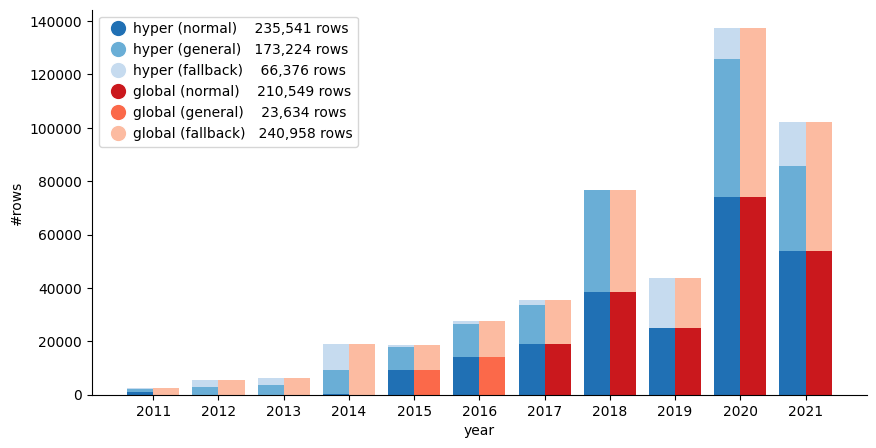

In [149]:
plt.figure(figsize=(10, 5))
handles =[]
c1, c2, c3 = sns.color_palette('Blues', 3)[::-1]
plot_bars(df_hyper, -.2, 0.4, c1, c2 , c3)
normal = df_hyper['normal_rows'].sum()
general = df_hyper['general_rows'].sum()
fallback = df_hyper['fallback_rows'].sum()
handles += [(f'hyper (normal)    {normal:,} rows', c1),
            (f'hyper (general)   {general:,} rows', c2),
            (f'hyper (fallback)    {fallback:,} rows', c3)]
c1, c2, c3 = sns.color_palette('Reds', 3)[::-1]
normal =   df_global['normal_rows'].sum()
general =  df_global['general_rows'].sum()
fallback = df_global['fallback_rows'].sum()
handles += [(f'global (normal)    {normal:,} rows', c1),
            (f'global (general)    {general:,} rows', c2),
            (f'global (fallback)   {fallback:,} rows', c3)]
plot_bars(df_global, .2, 0.4, c1, c2, c3)
xq = np.arange(len(df_hyper))
plt.xticks(xq, df_hyper['year'])
print('done')
sns.despine()
plt.ylabel('#rows')
plt.xlabel('year')

from matplotlib.lines import Line2D

# https://matplotlib.org/3.1.1/tutorials/intermediate/legend_guide.html
lgd_handles=[]
for h in handles:
    lgd_handles.append(Line2D([0], [0], marker='o', color='w', label=h[0],
                        markerfacecolor=h[1], markersize=12))
ax = plt.gca()
ax.legend(handles=lgd_handles, fontsize=10, handletextpad=0.05)

done


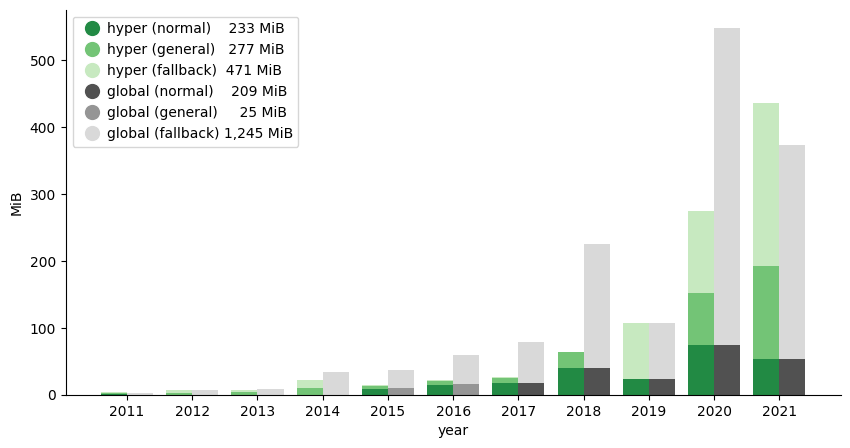

In [150]:
plt.figure(figsize=(10, 5))
handles =[]
c1, c2, c3 = sns.color_palette('Greens', 3)[::-1]
mem_factor = 1024 * 1024
mem_unit = 'MiB'
plot_bars_mem(df_hyper, -.2, 0.4, mem_factor, c1, c2 , c3)
normal = int(df_hyper['normal_mem'].sum() / mem_factor)
general = int(df_hyper['general_mem'].sum() / mem_factor)
fallback = int(df_hyper['fallback_mem'].sum() / mem_factor)
handles += [(f'hyper (normal)    {normal:,} {mem_unit}', c1),
            (f'hyper (general)   {general:,} {mem_unit}', c2),
            (f'hyper (fallback)  {fallback:,} {mem_unit}', c3)]
c1, c2, c3 = sns.color_palette('Greys', 3)[::-1]
normal =   int(df_global['normal_mem'].sum() / mem_factor)
general =  int(df_global['general_mem'].sum() / mem_factor)
fallback = int(df_global['fallback_mem'].sum() / mem_factor)
handles += [(f'global (normal)    {normal:,} {mem_unit}', c1),
            (f'global (general)     {general:,} {mem_unit}', c2),
            (f'global (fallback) {fallback:,} {mem_unit}', c3)]
plot_bars_mem(df_global, .2, 0.4, mem_factor, c1, c2, c3)
xq = np.arange(len(df_hyper))
plt.xticks(xq, df_hyper['year'])
print('done')
sns.despine()
plt.ylabel(mem_unit)
plt.xlabel('year')

from matplotlib.lines import Line2D

# https://matplotlib.org/3.1.1/tutorials/intermediate/legend_guide.html
lgd_handles=[]
for h in handles:
    lgd_handles.append(Line2D([0], [0], marker='o', color='w', label=h[0],
                        markerfacecolor=h[1], markersize=12))
ax = plt.gca()
ax.legend(handles=lgd_handles, fontsize=10, handletextpad=0.05)

In [171]:
# interpolation for full dataset (pretty off)
hyper_total = df_hyper['normal_mem'].sum() + df_hyper['general_mem'].sum() + df_hyper['fallback_mem'].sum()
global_total = df_global['normal_mem'].sum() + df_global['general_mem'].sum() + df_global['fallback_mem'].sum()

print('memory usage:: hyper {:.1f} MiB  global {:.1f} MiB'.format(
    hyper_total / mem_factor, global_total / mem_factor))

memory usage:: hyper 983.0 MiB  global 1480.5 MiB


In [172]:
# averages per row may be also interesting:

print('encoding 1 row in normal   (hyper): {:.2f} Kib'.format(
    df_hyper['normal_mem'].sum() / df_hyper['normal_rows'].sum() / 1024))
print('encoding 1 row in general  (hyper): {:.2f} Kib'.format(
    df_hyper['general_mem'].sum() / df_hyper['general_rows'].sum() / 1024))
print('encoding 1 row in fallback (hyper): {:.2f} Kib'.format(
    df_hyper['fallback_mem'].sum() / df_hyper['fallback_rows'].sum() / 1024))
print('----')
print('encoding 1 row in normal   (global): {:.2f} Kib'.format(
    df_global['normal_mem'].sum() / df_global['normal_rows'].sum() / 1024))
print('encoding 1 row in general  (global): {:.2f} Kib'.format(
    df_global['general_mem'].sum() / df_global['general_rows'].sum() / 1024))
print('encoding 1 row in fallback (global): {:.2f} Kib'.format(
    df_global['fallback_mem'].sum() / df_global['fallback_rows'].sum() / 1024))

encoding 1 row in normal   (hyper): 1.02 Kib
encoding 1 row in general  (hyper): 1.64 Kib
encoding 1 row in fallback (hyper): 7.28 Kib
----
encoding 1 row in normal   (global): 1.02 Kib
encoding 1 row in general  (global): 1.09 Kib
encoding 1 row in fallback (global): 5.29 Kib


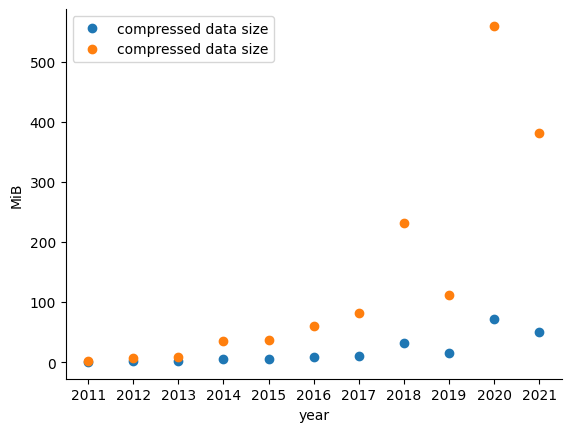

In [152]:
plt.plot(df_hyper['buf_size_compressed'] / mem_factor, 'o', label='compressed data size')
plt.plot(df_hyper['buf_size_uncompressed'] / mem_factor, 'o', label='compressed data size')
plt.xticks(xq, df_hyper['year'])
sns.despine()
plt.ylabel(mem_unit)
plt.xlabel('year')

plt.legend(loc='best')

In [153]:
# least complex normal-case
sorted(list(df['normal_case'].values), key=len)[0]

"Struct[(str,'actor'->Struct[(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str),(str,'id'->i64),(str,'login'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'payload'->Struct[(str,'commits'->List[Struct[(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'sha'->str),(str,'message'->str),(str,'url'->str)]]),(str,'head'->str),(str,'push_id'->i64),(str,'ref'->str),(str,'size'->i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'url'->str),(str,'id'->i64),(str,'name'->str)]),(str,'type'->str)]"

In [154]:
# most complex normal-case
sorted(list(df['normal_case'].values), key=len)[-1]

"Struct[(str,'created_at'->str),(str,'payload'->Struct[(str,'shas'->List[(str,str,str,str,boolean)]),(str,'size'->i64),(str,'ref'->str),(str,'head'->str)]),(str,'public'->boolean),(str,'type'->str),(str,'url'->str),(str,'actor'->str),(str,'actor_attributes'->Struct[(str,'login'->str),(str,'type'->str),(str,'gravatar_id'->str),(str,'email'->str)]),(str,'repository'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str),(str,'description'->str),(str,'watchers'->i64),(str,'stargazers'->i64),(str,'forks'->i64),(str,'fork'->boolean),(str,'size'->i64),(str,'owner'->str),(str,'private'->boolean),(str,'open_issues'->i64),(str,'has_issues'->boolean),(str,'has_downloads'->boolean),(str,'has_wiki'->boolean),(str,'language'->str),(str,'created_at'->str),(str,'pushed_at'->str),(str,'master_branch'->str)])]"

In [155]:
# least complex general_case
sorted(list(df['general_case'].values), key=len)[0]

"Struct[(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'org'=>Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]"

In [156]:
# most complex general_case
sorted(list(df['general_case'].values), key=len)[-1]

"Struct[(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'org'=>Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'payload'->Struct[(str,'action'=>str),(str,'before'=>str),(str,'comment'=>Struct[(str,'url'->str),(str,'html_url'->str),(str,'issue_url'->str),(str,'id'->i64),(str,'node_id'->str),(str,'user'->Struct[(str,'login'->str),(str,'id'->i64),(str,'node_id'->str),(str,'avatar_url'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'html_url'->str),(str,'followers_url'->str),(str,'following_url'->str),(str,'gists_url'->str),(str,'starred_url'->str),(str,'subscriptions_url'->str),(str,'organizations_url'->str),(str,'repos_url'->str),(str,'events_url'->str),(str,'received_events_url'->str),(str,'type'->str),(str,'site_admin'->boolean)]),(str,'created_at'->str),(str,'updated_

In [157]:
df_global['general_case'].iloc[0]

"Struct[(str,'actor'->Struct[(str,'avatar_url'->str),(str,'display_login'=>str),(str,'gravatar_id'->str),(str,'id'->i64),(str,'login'->str),(str,'url'->str)]),(str,'created_at'->str),(str,'id'->str),(str,'org'=>Struct[(str,'id'->i64),(str,'login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'payload'->Struct[(str,'before'->str),(str,'commits'->List[Struct[(str,'author'->Struct[(str,'email'->str),(str,'name'->str)]),(str,'distinct'->boolean),(str,'message'->str),(str,'sha'->str),(str,'url'->str)]]),(str,'distinct_size'->i64),(str,'head'->str),(str,'push_id'->i64),(str,'ref'->str),(str,'size'->i64)]),(str,'public'->boolean),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'type'->str)]"

In [158]:
df_global['normal_case'].iloc[0]

"Struct[(str,'id'->str),(str,'type'->str),(str,'actor'->Struct[(str,'id'->i64),(str,'login'->str),(str,'display_login'->str),(str,'gravatar_id'->str),(str,'url'->str),(str,'avatar_url'->str)]),(str,'repo'->Struct[(str,'id'->i64),(str,'name'->str),(str,'url'->str)]),(str,'payload'->Struct[(str,'push_id'->i64),(str,'size'->i64),(str,'distinct_size'->i64),(str,'ref'->str),(str,'head'->str),(str,'before'->str),(str,'commits'->List[Struct[(str,'sha'->str),(str,'author'->Struct[(str,'name'->str),(str,'email'->str)]),(str,'message'->str),(str,'distinct'->boolean),(str,'url'->str)]])]),(str,'public'->boolean),(str,'created_at'->str)]"

In [139]:
# -> prob. picks up the wrong normal-case/global case... -> selection routine may be off...